In [50]:
import math
import copy
import os
import time
import enum
import argparse
import polars as pl
# Visualization related imports
import matplotlib.pyplot as plt
import seaborn
from torch.utils.data import DataLoader, Dataset
# Deep learning related imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.hub import download_url_to_file
from torch.utils.data import Dataset
# Data manipulation related imports
# from torchtext.data import Dataset, BucketIterator, Field, Example
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

In [81]:
class BatteryData(Dataset):
    def __init__(self, data_dir, processor, final_cols) -> None:
        super().__init__()
        self.processor = processor
        # self.ares = self.load_data(data_dir)
        data = pl.read_parquet(data_dir)
        self.ares = self.processor.process_data(data.select(final_cols))

    def __len__(self):
        return self.ares.shape[0]
    
    def __getitem__(self, index):
        X = self.ares[:, :, :-1]
        Y = self.ares[:, :, -1]
        return X[index], Y[index]
    
    def load_data(self, data_dir):
        path_list = os.listdir(data_dir)
        data = []
        for item in os.listdir(data_dir):
            data.append(self.processor.process_data(pl.read_parquet(os.path.join(data_dir,item))))
        res = pl.concat(data)
        return res
    
    @staticmethod
    def get_data_info(data_dir):
        data_info={}
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                file_path = os.path.join(root, file)
                print(f"file: {file}")
                data = pl.read_parquet(file_path)
                yield data
class processor:
    def __init__(self, groups, seq_len, step_size) -> None:
        self.groups = groups
        self.seq_len = seq_len
        self.step_size = step_size
    
    def process_data(self, data:pl.DataFrame):
        final_res = []
        for item in data.groupby(self.groups):
            data_tmp = item[1]
            data_tmp = data_tmp.drop('cycle')
            l = data_tmp.shape[0]
            if l < self.seq_len:
                continue
            steps = int((l-self.seq_len)//self.step_size+1)
            for i in range(steps):
                X_tensor = torch.from_numpy(data_tmp[self.step_size*i:self.step_size*i+self.seq_len].to_numpy())
                final_res.append(X_tensor)
            X_tensor = torch.from_numpy(data_tmp[-self.seq_len:].to_numpy())
            final_res.append(X_tensor)
        ares = torch.cat(final_res)
        ares = ares.reshape((-1, self.seq_len, data_tmp.shape[1]))
        return ares

In [343]:
class BatteryData(Dataset):
    def __init__(self, data_dir, processor, final_cols) -> None:
        super().__init__()
        self.processor = processor
        # self.ares = self.load_data(data_dir)
        data = pl.read_parquet(data_dir)
        self.ares, self.ares_y = self.processor.process_data(data.select(final_cols))

    def __len__(self):
        return self.ares.shape[0]
    
    def __getitem__(self, index):
        X = self.ares
        Y = self.ares_y
        return X[index], Y[index]
    
    def load_data(self, data_dir):
        path_list = os.listdir(data_dir)
        data = []
        for item in os.listdir(data_dir):
            data.append(self.processor.process_data(pl.read_parquet(os.path.join(data_dir,item))))
        res = pl.concat(data)
        return res
    
    @staticmethod
    def get_data_info(data_dir):
        data_info={}
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                file_path = os.path.join(root, file)
                print(f"file: {file}")
                data = pl.read_parquet(file_path)
                yield data
class processor:
    def __init__(self, groups, seq_len, step_size) -> None:
        self.groups = groups
        self.seq_len = seq_len
        self.step_size = step_size
    
    def process_data(self, data:pl.DataFrame):
        final_res = []
        final_y = []
        for item in data.groupby(self.groups):
            data_tmp = item[1]
            data_tmp = data_tmp.drop('cycle')
            l = data_tmp.shape[0]
            if l < self.seq_len:
                continue
            steps = int((l-self.seq_len)//self.step_size+1)
            for i in range(steps-1):
                X_tensor = torch.from_numpy(data_tmp[self.step_size*i:self.step_size*i+self.seq_len].to_numpy())
                y_tensor = torch.from_numpy(data_tmp[self.step_size*(i+1):self.step_size*(i+1)+self.seq_len].select('D135_diff').to_numpy())
                final_res.append(X_tensor)
                final_y.append(y_tensor)
            X_tensor = torch.from_numpy(data_tmp[-self.seq_len-self.step_size:-self.step_size].to_numpy())
            if X_tensor.shape[0] < 10: continue
            y_tensor = torch.from_numpy(data_tmp[-self.seq_len:].select('D135_diff').to_numpy())
            final_res.append(X_tensor)
            final_y.append(y_tensor)
        ares = torch.cat(final_res)
        ares = ares.reshape((-1, self.seq_len, data_tmp.shape[1]))
        ares_y = torch.cat(final_y)
        ares_y = ares_y.reshape((-1, self.seq_len, 1))
        return ares, ares_y

In [4]:
import torch
import math
import copy
import os
import time
import enum
import argparse
import polars as pl
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.hub import download_url_to_file
import seaborn as sns


class MLP(nn.Module):
    def __init__(self, model_dimension):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(
            nn.Linear(
                in_features=model_dimension,
                out_features=256,
                bias=True
            ),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.classifica = nn.Linear(64, 2)

    def forward(self, x):
        fc1 = F.dropout(self.hidden1(x))
        fc2 = F.dropout(self.hidden2(fc1))
        output = self.classifica(fc2)
        return F.log_softmax(output)


class PositionalEncoding(nn.Module):

    def __init__(self, model_dimension, dropout_probability, expected_max_sequence_length=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_probability)
        position_id = torch.arange(0, expected_max_sequence_length).unsqueeze(1)
        frequencies = torch.pow(10000., -torch.arange(0, model_dimension, 2, dtype=torch.float) / model_dimension)

        # Checkout playground.py for visualization of how these look like (it's super simple don't get scared)
        positional_encodings_table = torch.zeros(expected_max_sequence_length, model_dimension)
        positional_encodings_table[:, 0::2] = torch.sin(position_id * frequencies)  # sine on even positions
        positional_encodings_table[:, 1::2] = torch.cos(position_id * frequencies)  # cosine on odd positions

        self.register_buffer('positional_encodings_table', positional_encodings_table)

    def forward(self, embeddings_batch):
        assert embeddings_batch.ndim == 3 and embeddings_batch.shape[-1] == self.positional_encodings_table.shape[1], \
            f'Expected (batch size, max token sequence length, model dimension) got {embeddings_batch.shape}'

        positional_encodings = self.positional_encodings_table[:embeddings_batch.shape[1]]
        return self.dropout(embeddings_batch + positional_encodings)

class DTN_model(nn.Module):
    def __init__(self, model_dimension, number_of_heads, number_of_layers,d_hid, dropout_probability, number_of_var,
                 hidden_dimension_list,in_channel, out_channel, kernel_size, stride):
        super().__init__()
        # Periodic Embeddings
        # two different encoders and decoders
        EncoderLayer = nn.TransformerEncoderLayer(d_model=model_dimension,
                                                  nhead=number_of_heads,dim_feedforward=d_hid, batch_first=True)
        self.encoder = nn.TransformerEncoder(EncoderLayer, num_layers=number_of_layers)
        self.fw_embedding = nn.Linear(number_of_var, model_dimension)
        self.bw_embedding = nn.Linear(number_of_var, model_dimension)
        self.pos_embedding = PositionalEncoding(model_dimension, dropout_probability)

        self.decoder = nn.Conv1d(in_channel, out_channel, kernel_size, stride)
        self.mlp = nn.ModuleList([nn.Sequential(nn.Linear(int((model_dimension - kernel_size)/stride+1),hidden_dimension_list[0]),nn.ReLU())]
                                 +[nn.Sequential(nn.Linear(hidden_dimension_list[i-1],hidden_dimension_list[i]),nn.ReLU()) for i in range(1,len(hidden_dimension_list))])
        self.init_params()

    def init_params(self):
        # I tested both PyTorch's default initialization and this, and xavier has tremendous impact! I didn't expect
        # that the model's perf, with normalization layers, is so dependent on the choice of weight initialization.
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    @staticmethod
    def get_key_padding_mask(tokens):
        tmp=tokens[:,:,0].squeeze()
        tmp = tmp.reshape((-1,tokens.shape[1]))
        key_padding_mask = torch.zeros(tmp.size())
        key_padding_mask[tmp == 0] = -torch.inf
        return key_padding_mask
    
    @staticmethod
    def get_bw_mask(bw_tensor):
        bw_mask = nn.Transformer.generate_square_subsequent_mask(bw_tensor.size()[-2])
        return bw_mask
    
    def encode(self, input, src_mask):
        input_embeddings = self.fw_embedding(input)
        input_embeddings = self.pos_embedding(input_embeddings)
        input_repr = self.encoder(input_embeddings, src_key_padding_mask=src_mask)
        return input_repr
    
    def decode(self, input):
        return bw_repr
        
    def forward(self, input, src_mask):
        input_repr = self.encode(input, src_mask)
        # decode_repr = self.decoder(input_repr.permute([0,2,1])).permute([0,2,1])
        decode_repr = self.decoder(input_repr)
        for m in self.mlp:
            decode_repr = m(decode_repr)
        # for m in self.mlp:
        #     input_repr = m(input_repr)
        # pred = F.log_softmax(input_repr,dim=1)
        return decode_repr

In [378]:
EncoderLayer = nn.TransformerEncoderLayer(d_model=512,nhead=4, batch_first=True)
encoder = nn.TransformerEncoder(EncoderLayer, num_layers=2)
pos_embedding = PositionalEncoding(512, 0.2)

In [379]:
t1 = torch.rand(8,10,512)
print(t1.shape)
t1 = pos_embedding(t1)
t1d = encoder(t1)
print(t1d.shape)

torch.Size([8, 10, 512])
torch.Size([8, 10, 512])


In [306]:
m = nn.Conv1d(512, 1024, 2, stride=2)

In [380]:
m = nn.Conv1d(10, 10, 10, stride=2)
m(t1d).shape

torch.Size([8, 10, 252])

In [309]:
(512-10)/2+1
(model_dimension - kernel_size)/stride+1

252.0

In [307]:
m(t1d.permute([0,2,1])).shape

torch.Size([8, 1024, 5])

In [302]:
g = m(t1d.permute([0,2,1])).permute([0,2,1])
nlay = nn.Linear(1024, 1)
nlay(g).shape

torch.Size([8, 5, 1])

In [305]:
g = m(t1d)
nlay = nn.Linear(252, 1)
nlay(g).shape

torch.Size([8, 10, 1])

In [ ]:
g = m(t1d)
nlay = nn.Linear(252, 2)
nlay(g).reshape((8, 10, 1)).shape

In [250]:
x = torch.randn(200,6)
x = x.unsqueeze(1)
print(x.shape)

torch.Size([200, 1, 6])


In [171]:
def train_loop(data_dir, model, loss_fn, optimizer, final_cols):
    size = 0
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss=0
    batch = 0
    for file in [x for x in os.listdir(data_dir) if 'parquet' in x]:
        print(os.path.join(data_dir,file))
        # key = file.split('_')[0]
        battery_data = BatteryData(os.path.join(data_dir,file), dataProcess, final_cols)
        dataloader = DataLoader(dataset=battery_data,batch_size=4,shuffle=True,num_workers=2)
        size += len(dataloader.dataset)
        # loss_file[key] = []
        tmp_loss=[]
        for _batch, (X, y) in enumerate(dataloader):
            # print(batch)
            # Compute prediction and loss
            # tmp = torch.ones(y.shape)
            # y2 = tmp-y
            # y = y.unsqueeze(dim=2)
            # y2 = y2.unsqueeze(dim=2)
            # new_y = torch.cat([y,y2],dim=2)
            # new_y = new_y.cuda()
            # print("X",X.shape)
            pred = model(X.float().cuda(), model.get_key_padding_mask(X.cuda()).float().cuda())

            loss = loss_fn(pred.reshape((X.shape[0],X.shape[1],-1)).float(), y.float().cuda())
            train_loss+=loss.item()
            tmp_loss.append(loss.item())
            # Backpropagation
            loss.backward()
            # for name, param in MyModel.named_parameters():
            #     if param.requires_grad and param.grad is not None:
            #         print(name)
            #         print(param.grad)
            #         print(f"grad shape: {param.grad.shape}")
            optimizer.step()
            optimizer.zero_grad()
            batch+=1
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                # loss_train.append(sum(tmp_loss)/len(tmp_loss))
                tmp_loss=[]
    return train_loss

In [442]:
def getTestResult(data_dir, model, loss_fn, final_cols):
    model.eval()
    size = 0
    batch = 0
    loss_file = {}
    for file in os.listdir(data_dir):
        print(os.path.join(data_dir,file))
        key = file.split('.')[0]
        battery_data = BatteryData(os.path.join(data_dir,file), dataProcess, final_cols)
        dataloader = DataLoader(dataset=battery_data,batch_size=4,shuffle=False,num_workers=2)
        size += len(dataloader.dataset)
        loss_file[key] = []
        for _batch, (X, y) in enumerate(dataloader):
            # print(batch)
            # Compute prediction and loss
            # print("X",X.shape)
            pred = model(X.float().cuda(), model.get_key_padding_mask(X.cuda()).float().cuda())

            loss = loss_fn(pred.reshape((X.shape[0],X.shape[1],-1)), y.cuda())

            # Backpropagation
            # loss.backward()
            # optimizer.step()
            # optimizer.zero_grad()
            batch+=1
            loss_file[key].append(loss.item())
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_file

In [345]:
dataProcess = processor(['cycle'], 10, 5)

In [334]:
model_dimension = 512
number_of_heads = 4
number_of_var = 114
number_of_layers = 3
dropout_probability = 0.4
hidden_dimension_list = [512,64,16,1]
d_hid = 512
in_channel = 10
out_channel = 10
kernel_size = 10
stride = 2

In [335]:
MyModel = DTN_model(model_dimension, number_of_heads, number_of_layers,d_hid, dropout_probability,
                    number_of_var, hidden_dimension_list, in_channel,out_channel,kernel_size,stride)

In [336]:
optimizer = Adam(MyModel.parameters(),lr=0.000005, betas=(0.9, 0.98), eps=1e-9)

In [339]:
MyModel = MyModel.cuda()
loss = nn.MSELoss()
loss=loss.cuda()
final_cols = [f"D135_{i}_dv" for i in range(1,113)]+['D135_diff','D135_std_max']+['cycle']

In [ ]:
batch_size=4
train_loop('processed_data/normal_sample',MyModel,loss,optimizer, final_cols)

In [346]:
epochs = 60
batch_size=4
all_losses=[]
for epoch in range(1,epochs+1):
    train_loss = train_loop('processed_data/normal_sample/charge_data',MyModel,loss,optimizer, final_cols)
    all_losses.append(train_loss)
    if epoch % 10 == 0:
        torch.save({
                'epoch': epoch,
                'model_state_dict': MyModel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f"model/10_5_model_charge_epoch{epoch}.pt")

processed_data/normal_sample/charge_data/D105_4_5.parquet
loss: 117.308914  [  404/  560]
processed_data/normal_sample/charge_data/D107_4_5.parquet
loss: 182.080841  [  804/  978]
processed_data/normal_sample/charge_data/D131_4_5.parquet
loss: 95.380058  [ 1204/ 1433]
processed_data/normal_sample/charge_data/D162_4_5.parquet
loss: 206.874130  [ 1604/ 1671]
processed_data/normal_sample/charge_data/D180_4_5.parquet
loss: 73.906776  [ 2004/ 2060]
processed_data/normal_sample/charge_data/D246_4_5.parquet
loss: 126.169693  [ 2404/ 2737]
processed_data/normal_sample/charge_data/D280_4_5.parquet
loss: 85.701378  [ 2804/ 4004]
loss: 87.478294  [ 3204/ 4004]
loss: 78.169167  [ 3604/ 4004]
loss: 41.479095  [ 4004/ 4004]
processed_data/normal_sample/charge_data/D296_4_5.parquet
processed_data/normal_sample/charge_data/D119_4_5.parquet
loss: 44.432220  [ 4404/ 4940]
loss: 25.296204  [ 4804/ 4940]
processed_data/normal_sample/charge_data/D105_4_5.parquet
loss: 14.206601  [  404/  560]
processed_dat

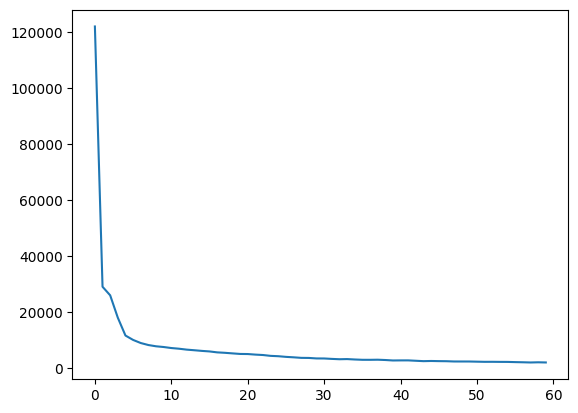

In [347]:
plt.plot(all_losses)
plt.show()

In [254]:
all_losses[-1]

2606.0253317654133

In [262]:
losses_res = pd.DataFrame({'epoch':[i for i in range(1,61)], 'total_loss':all_losses})
losses_res.to_csv('result_plot/charge_losses.csv', index=False)

In [452]:
loss = nn.MSELoss()
loss=loss.cuda()
loss_norm = getTestResult('processed_data/normal_sample/charge_data',MyModel,loss, final_cols)

processed_data/normal_sample/charge_data/D105_3.parquet
loss: 44.637160  [  404/ 1273]
loss: 17.484715  [  804/ 1273]
loss: 22.038391  [ 1204/ 1273]
processed_data/normal_sample/charge_data/D107_3.parquet
loss: 35.093130  [ 1604/ 2276]
loss: 54.266623  [ 2004/ 2276]
processed_data/normal_sample/charge_data/D131_3.parquet
loss: 34.031995  [ 2404/ 3325]
loss: 67.946455  [ 2804/ 3325]
loss: 40.592917  [ 3204/ 3325]
processed_data/normal_sample/charge_data/D162_3.parquet
loss: 29.245500  [ 3604/ 3975]
processed_data/normal_sample/charge_data/D180_3.parquet
loss: 82.853327  [ 4004/ 4906]
loss: 44.830099  [ 4404/ 4906]
loss: 79.390357  [ 4804/ 4906]
processed_data/normal_sample/charge_data/D246_3.parquet
loss: 51.587719  [ 5204/ 6768]
loss: 21.422582  [ 5604/ 6768]
loss: 16.297246  [ 6004/ 6768]
loss: 17.573579  [ 6404/ 6768]
processed_data/normal_sample/charge_data/D280_3.parquet
loss: 20.878058  [ 6804/ 9813]
loss: 43.902090  [ 7204/ 9813]
loss: 19.597796  [ 7604/ 9813]
loss: 43.452235  [ 

In [443]:
loss = nn.MSELoss()
loss=loss.cuda()
loss_file = getTestResult('processed_data/normal_sample/discharge_data',MyModel,loss, final_cols)

processed_data/neg_sample/discharge_data/D1_3.parquet
loss: 51.507816  [  404/ 1935]
loss: 29.158547  [  804/ 1935]
loss: 70.889076  [ 1204/ 1935]
loss: 32.852042  [ 1604/ 1935]
processed_data/neg_sample/discharge_data/D13_3.parquet
loss: 25.247144  [ 2004/ 4609]
loss: 36.840200  [ 2404/ 4609]
loss: 32.192425  [ 2804/ 4609]
loss: 47.819919  [ 3204/ 4609]
loss: 17.195439  [ 3604/ 4609]
loss: 36.853351  [ 4004/ 4609]
loss: 50.290314  [ 4404/ 4609]
processed_data/neg_sample/discharge_data/D2_3.parquet
loss: 51.523701  [ 4804/ 7333]
loss: 34.067330  [ 5204/ 7333]
loss: 30.817356  [ 5604/ 7333]
loss: 151.015832  [ 6004/ 7333]
loss: 19.901985  [ 6404/ 7333]
loss: 66.813261  [ 6804/ 7333]
loss: 48.080221  [ 7204/ 7333]
processed_data/neg_sample/discharge_data/D3_3.parquet
loss: 165.536634  [ 7604/ 9184]
loss: 715.892429  [ 8004/ 9184]
loss: 102.902309  [ 8404/ 9184]
loss: 81.460563  [ 8804/ 9184]
processed_data/neg_sample/discharge_data/D4_3.parquet
loss: 76.227690  [ 9204/12569]
loss: 15.175

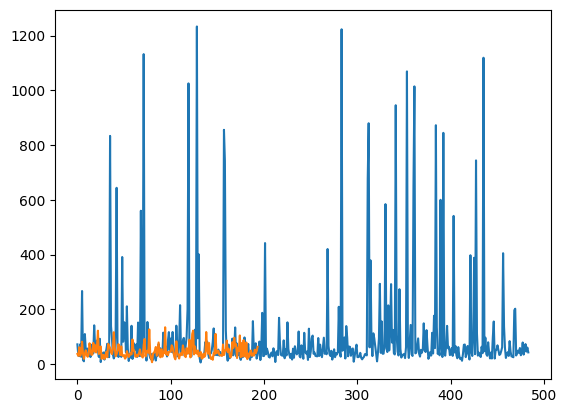

In [496]:
plt.plot(loss_file['D1_3'])
plt.plot(loss_norm['D296_3'])
plt.show()

In [363]:
path = 'model/model_0816.pt'
torch.save(MyModel.state_dict(),path)

In [336]:
df = pl.read_parquet('processed_data/normal_sample/D280_3.parquet')

In [339]:
3472212/114

30458.0

In [ ]:
for name, param in MyModel.named_parameters():
    if param.requires_grad:
        print(name) 
        print(param)

In [291]:
pred = MyModel(X.float().cuda(), MyModel.get_key_padding_mask(X.cuda()).float().cuda())
pred.shape

torch.Size([8, 5, 2])

In [386]:
final_cols = [f"D135_{i}_dv" for i in range(1,113)]+['D135_diff_max','D135_std_max']+['cycle']

In [289]:
df = pl.read_parquet('processed_data/D246_3.parquet')
df.head()

D141,D22,D24_int,D44,D40,D41,D52,D117,D133,D334,D356,D290,D135_diff,D136_diff,soc_diff,D135_1,D135_2,D135_3,D135_4,D135_5,D135_6,D135_7,D135_8,D135_9,D135_10,D135_11,D135_12,D135_13,D135_14,D135_15,D135_16,D135_17,D135_18,D135_19,D135_20,D135_21,D135_22,…,D135_78_dv,D135_79_dv,D135_80_dv,D135_81_dv,D135_82_dv,D135_83_dv,D135_84_dv,D135_85_dv,D135_86_dv,D135_87_dv,D135_88_dv,D135_89_dv,D135_90_dv,D135_91_dv,D135_92_dv,D135_93_dv,D135_94_dv,D135_95_dv,D135_96_dv,D135_97_dv,D135_98_dv,D135_99_dv,D135_100_dv,D135_101_dv,D135_102_dv,D135_103_dv,D135_104_dv,D135_105_dv,D135_106_dv,D135_107_dv,D135_108_dv,D135_109_dv,D135_110_dv,D135_111_dv,D135_112_dv,label,cycle
f64,f32,f64,f64,f64,f64,f32,f64,f64,f32,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32
331.67223,2.0535,63.0,0.0,64.010663,62.500927,13.843116,11.5,4.0,102.104965,50.785416,433.678589,20.755216,1.38943,1.509736,3856.883057,3865.021729,3866.516357,3863.784912,3865.753418,3865.894775,3862.873779,3867.673096,3863.77002,3861.332031,3865.51001,3861.317139,3862.738525,3864.170654,3866.771973,3860.525635,3863.10791,3865.451172,3863.180908,3863.680664,3866.378418,3866.851562,…,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-2.0,-4.0,-3.0,-3.0,-2.0,-2.0,-3.0,-2.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-4.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,0,1
338.672289,4.497108,64.0,0.0,64.5,63.0,13.74482,11.5,4.0,102.099998,85.640961,433.619263,20.520482,1.5,1.5,3859.03125,3867.096436,3868.686768,3865.867432,3867.816895,3867.915771,3864.937256,3869.74707,3865.86499,3863.354248,3867.515625,3863.265137,3864.725342,3866.146973,3868.85791,3862.655518,3865.064941,3867.496338,3865.16626,3865.708496,3868.387939,3868.814453,…,-2.0,-3.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-2.0,-3.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-2.0,0,1
270.712554,1.676017,68.0,0.0,69.0,67.5,13.832381,18.887013,0.0,101.999916,48.525585,441.667816,17.644156,0.795671,1.5,3928.083984,3935.490967,3936.484863,3934.515137,3935.320312,3935.979248,3932.357666,3936.995605,3934.807861,3932.995605,3936.670166,3933.295166,3934.541992,3936.016357,3937.84668,3932.855469,3934.657227,3936.101318,3934.646729,3934.996582,3936.56958,3937.075439,…,-2.0,-2.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-1.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0,1
260.252174,1.71408,69.0,0.0,69.545819,68.042809,13.834348,18.782776,0.0,101.994987,49.664536,442.263123,17.335117,0.630936,1.50301,3934.494873,3941.814453,3942.820801,3940.907959,3941.557617,3942.228516,3938.567871,3943.211426,3941.325195,3939.570557,3943.203613,3939.921631,3941.115479,3942.624512,3944.222412,3939.513672,3941.084229,3942.443359,3941.072266,3941.38623,3942.826172,3943.36377,…,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-1.0,-2.0,-2.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-1.0,-2.0,-2.0,0,1
326.669168,1.741807,66.0,0.0,66.846936,65.427767,13.841995,13.5,3154.681989,102.200623,45.933605,441.065155,17.665103,1.023139,1.419168,3924.232666,3931.700195,3932.694092,3930.70459,3931.573242,3932.286133,3928.578857,3933.38501,3930.885986,3928.95752,3932.707031,3929.228516,3930.53125,3931.932861,3933.950684,3928.727539,3930.655518,3932.212891,3930.629395,3931.00415,3932.689697,3933.142578,…,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-8.0,-9.0,-9.0,-9.0,-10.0,-9.0,-10.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-8.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,0,2


In [247]:
dataProcess = processor(['cycle'], 10, 5)
battery_data = BatteryData('processed_data/normal_sample/charge_data/D280_4_5.parquet', dataProcess, final_cols)
dataloader = DataLoader(dataset=battery_data,batch_size=8,shuffle=True,num_workers=2)

In [13]:
df = pl.read_parquet('processed_data/D3_3.parquet')
temp = dataProcess.process_data(df)

In [248]:
for batch_idx, data_batch in enumerate(dataloader):
    print(batch_idx)
    X, y = data_batch
    break

0


In [249]:
X.shape

torch.Size([8, 10, 115])

In [ ]:
MyModel(X.float().cuda(), MyModel.get_key_padding_mask(X.cuda()).float().cuda())

In [135]:
df = pl.read_parquet('processed_data/D3_3.parquet')
df.head()

D141,D22,D24_int,D44,D40,D41,D52,D117,D133,D334,D356,D290,D135_diff,D136_diff,soc_diff,D135_1,D135_2,D135_3,D135_4,D135_5,D135_6,D135_7,D135_8,D135_9,D135_10,D135_11,D135_12,D135_13,D135_14,D135_15,D135_16,D135_17,D135_18,D135_19,D135_20,D135_21,D135_22,…,D135_78_dv,D135_79_dv,D135_80_dv,D135_81_dv,D135_82_dv,D135_83_dv,D135_84_dv,D135_85_dv,D135_86_dv,D135_87_dv,D135_88_dv,D135_89_dv,D135_90_dv,D135_91_dv,D135_92_dv,D135_93_dv,D135_94_dv,D135_95_dv,D135_96_dv,D135_97_dv,D135_98_dv,D135_99_dv,D135_100_dv,D135_101_dv,D135_102_dv,D135_103_dv,D135_104_dv,D135_105_dv,D135_106_dv,D135_107_dv,D135_108_dv,D135_109_dv,D135_110_dv,D135_111_dv,D135_112_dv,label,cycle
f64,f32,f64,f64,f64,f64,f32,f64,f64,f32,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32
420.467091,8.671762,60.0,0.0,61.059448,59.595541,13.728662,25.0,6.0,101.300003,77.442734,430.400879,19.021231,2.064756,1.463907,3837.836426,3840.528564,3834.917236,3834.110352,3836.656006,3834.972412,3838.350342,3836.785645,3839.059326,3836.146484,3840.698486,3840.208008,3839.390625,3839.902344,3834.250488,3843.44165,3837.745117,3834.310059,3847.250488,3846.467041,3845.549805,3842.027588,…,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-3.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0,1
421.984733,8.987022,61.0,0.0,61.5,60.0,13.751908,25.0,6.0,101.300003,77.593498,430.894318,18.862595,1.896947,1.5,3842.045898,3844.73291,3839.221436,3838.450439,3840.961914,3839.26709,3842.648926,3841.099121,3843.343506,3840.450439,3844.954102,3844.511475,3843.679443,3844.183105,3838.679443,3847.687012,3842.030518,3838.69458,3851.503906,3850.770996,3849.862549,3846.320557,…,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-3.0,-3.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0,1
420.342308,5.921923,44.0,0.0,45.5,44.0,13.881346,26.534615,199.953846,101.00573,37.85178,412.490112,8.505769,1.0,1.5,3679.640381,3680.576904,3678.209717,3677.93457,3678.632812,3677.988525,3679.957764,3679.14624,3680.009521,3678.925049,3680.813477,3680.459717,3680.080811,3679.97876,3677.899902,3681.942383,3678.976807,3677.605713,3683.626953,3682.876953,3682.484619,3681.023193,…,111.0,110.0,110.0,110.0,112.0,108.0,112.0,107.0,109.0,110.0,112.0,110.0,113.0,107.0,111.0,108.0,110.0,110.0,111.0,109.0,112.0,109.0,112.0,108.0,110.0,108.0,110.0,108.0,114.0,108.0,113.0,110.0,111.0,109.0,112.0,0,2
407.357602,25.350107,45.0,0.0,46.146681,44.675589,13.879229,27.239829,196.895075,101.057861,38.384964,411.945343,9.304069,1.0,1.471092,3676.593262,3677.575928,3675.383301,3674.802979,3675.578125,3674.976562,3677.162842,3676.316895,3677.214111,3675.959229,3678.01709,3677.500977,3677.432617,3677.087891,3674.920654,3679.222656,3676.199219,3674.473145,3680.907959,3680.154297,3679.796631,3678.406738,…,-72.0,-71.0,-74.0,-72.0,-72.0,-72.0,-75.0,-71.0,-71.0,-72.0,-75.0,-72.0,-72.0,-72.0,-73.0,-71.0,-73.0,-71.0,-74.0,-72.0,-72.0,-72.0,-74.0,-71.0,-71.0,-69.0,-73.0,-70.0,-73.0,-71.0,-75.0,-72.0,-72.0,-70.0,-74.0,0,2
440.396215,8.752927,46.0,0.0,47.276759,45.657895,13.850562,30.636606,191.751626,101.025276,41.584671,414.281219,10.480189,0.682732,1.618865,3695.394531,3696.570557,3693.871582,3693.518066,3694.242432,3693.59082,3695.851074,3695.078613,3695.858154,3694.653564,3696.844482,3696.36792,3696.133057,3696.075195,3693.587891,3698.396729,3695.050293,3693.164307,3700.37793,3699.610352,3699.256592,3697.592529,…,-17.0,-18.0,-17.0,-18.0,-17.0,-18.0,-19.0,-18.0,-19.0,-18.0,-18.0,-18.0,-18.0,-17.0,-18.0,-19.0,-17.0,-18.0,-18.0,-19.0,-18.0,-18.0,-17.0,-17.0,-17.0,-18.0,-17.0,-17.0,-18.0,-17.0,-17.0,-18.0,-17.0,-18.0,-18.0,0,2


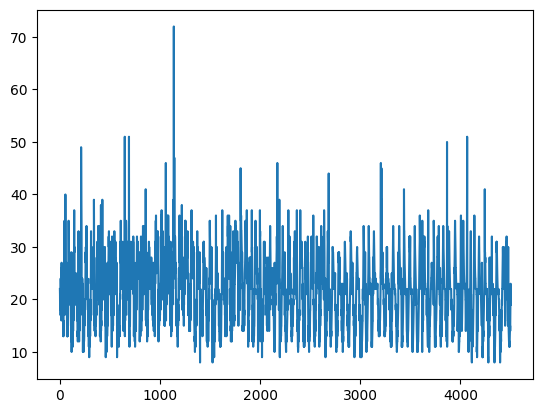

In [294]:
plt.plot(df['D135_diff_max'].to_list())
plt.show()

In [ ]:
data_dir='processed_data'
for file in os.listdir(data_dir):
    df = pl.read_parquet(os.path.join(data_dir,file))
    print(file)
    print(df['label'].value_counts())

In [519]:
from torchviz import make_dot

In [520]:
y = MyModel(X.float().cuda(), MyModel.get_key_padding_mask(X.cuda()).float().cuda())
g = make_dot(y)

In [522]:
g.render('result_plot/my_model', view=False)

'result_plot/my_model.pdf'

In [527]:
data_tmp = pl.read_parquet('processed_data/neg_sample/charge_data/D440_4_5.parquet')

In [ ]:
data_tmp.columns

## 使用异常样本做验证

In [9]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [350]:
class processor2:
    def __init__(self, groups, seq_len, step_size) -> None:
        self.groups = groups
        self.seq_len = seq_len
        self.step_size = step_size
    
    def process_data(self, data:pl.DataFrame):
        final_res = []
        final_y = []
        for item in data.groupby(self.groups):
            data_tmp = item[1]
            data_tmp = data_tmp.drop('cycle')
            l = data_tmp.shape[0]
            if l < self.seq_len:
                continue
            steps = int((l-self.seq_len)//self.step_size+1)
            for i in range(steps-1):
                X_tensor = torch.from_numpy(data_tmp[self.step_size*i:self.step_size*i+self.seq_len].drop('samplingtimesec').to_numpy())
                y_tensor = torch.from_numpy(data_tmp[self.step_size*(i+1):self.step_size*(i+1)+self.seq_len].select(['D135_diff','samplingtimesec']).to_numpy())
                final_res.append(X_tensor)
                final_y.append(y_tensor)
            X_tensor = torch.from_numpy(data_tmp[-self.seq_len-self.step_size:-self.step_size].drop('samplingtimesec').to_numpy())
            if X_tensor.shape[0] < 10: continue
            y_tensor = torch.from_numpy(data_tmp[-self.seq_len:].select(['D135_diff','samplingtimesec']).to_numpy())
            final_res.append(X_tensor)
            final_y.append(y_tensor)
        ares = torch.cat(final_res)
        ares = ares.reshape((-1, self.seq_len, data_tmp.shape[1]-1))
        # print(f"final_y[0]:{final_y[0].shape}")
        ares_y = torch.cat(final_y)
        ares_y = ares_y.reshape((-1, self.seq_len, 2))
        return ares, ares_y

In [351]:
dataProcess = processor2(['cycle'], 10, 5)

In [352]:
def getTestResult(data_dir, model, loss_fn, dataProcess, final_cols):
    # model.eval()
    size = 0
    batch = 0
    loss_file = {}
    for file in [x for x in os.listdir(data_dir) if 'parquet' in x]:
        print(os.path.join(data_dir,file))
        key = file.split('.')[0]
        battery_data = BatteryData(os.path.join(data_dir,file), dataProcess, final_cols)
        dataloader = DataLoader(dataset=battery_data,batch_size=1,shuffle=False,num_workers=1)
        size += len(dataloader.dataset)
        loss_file[key] = {'loss':[],'samplingtimesec':[]}
        for _batch, (X, y) in enumerate(dataloader):
            y_true = torch.unsqueeze(y[:,:,0], 2)
            timesec = np.squeeze(y[:,:,1].numpy())[-1]
            pred = model(X.float().cuda(), model.get_key_padding_mask(X.cuda()).float().cuda())
            loss = loss_fn(pred.reshape((X.shape[0],X.shape[1],-1)), y_true.cuda())
            batch+=1
            loss_file[key]['loss'].append(loss.item())
            loss_file[key]['samplingtimesec'].append(timesec)
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        del battery_data
        del dataloader
    return loss_file

In [355]:
data_dir = 'processed_data/neg_sample/charge_data'
file = 'D1_4_5.parquet'
final_cols = [f"D135_{i}_dv" for i in range(1,113)]+['D135_diff','D135_std_max']+['cycle','samplingtimesec']
# battery_data = BatteryData(os.path.join(data_dir,file), dataProcess, final_cols)

In [537]:
data_tmp = pl.read_parquet(os.path.join(data_dir,file))

In [549]:
data_tmp['samplingtimesec'].is_null().sum()

0

In [88]:
battery_data = BatteryData(os.path.join(data_dir,file), dataProcess, final_cols)
dataloader = DataLoader(dataset=battery_data,batch_size=1,shuffle=False,num_workers=1)
for _batch, (X,y) in enumerate(dataloader):
    print(X.shape)
    print(y.shape)
    break

torch.Size([1, 10, 114])
torch.Size([1, 10, 2])


In [44]:
np.squeeze(y[:,:,1].numpy())[-1]

1660144498000.0

In [ ]:
MyModel.load_state_dict(torch.load('model/model_charge_epoch20.pt')['model_state_dict'])
MyModel.cuda()

In [356]:
loss_fn = nn.MSELoss()
loss_fn = loss_fn.cuda()
loss_file = getTestResult('processed_data/neg_sample/charge_data',MyModel,loss_fn,dataProcess, final_cols)

processed_data/neg_sample/charge_data/D1_4_5.parquet
loss: 1.713842  [  101/  799]
loss: 0.106329  [  201/  799]
loss: 1.001399  [  301/  799]
loss: 1.439166  [  401/  799]
loss: 6.365016  [  501/  799]
loss: 4.203693  [  601/  799]
loss: 1.341332  [  701/  799]
processed_data/neg_sample/charge_data/D13_4_5.parquet
loss: 4.816848  [  801/ 1925]
loss: 0.924362  [  901/ 1925]
loss: 0.771896  [ 1001/ 1925]
loss: 1.538447  [ 1101/ 1925]
loss: 9.433642  [ 1201/ 1925]
loss: 0.060457  [ 1301/ 1925]
loss: 0.912574  [ 1401/ 1925]
loss: 1.868864  [ 1501/ 1925]
loss: 0.744761  [ 1601/ 1925]
loss: 2.212709  [ 1701/ 1925]
loss: 4.160299  [ 1801/ 1925]
loss: 0.523609  [ 1901/ 1925]
processed_data/neg_sample/charge_data/D2_4_5.parquet
loss: 17.696855  [ 2001/ 3048]
loss: 0.544021  [ 2101/ 3048]
loss: 7.168971  [ 2201/ 3048]
loss: 1.333604  [ 2301/ 3048]
loss: 0.864675  [ 2401/ 3048]
loss: 0.705834  [ 2501/ 3048]
loss: 4.807637  [ 2601/ 3048]
loss: 0.114079  [ 2701/ 3048]
loss: 0.161706  [ 2801/ 3048]

In [112]:
def format_time(sampletime):
    time_instance = datetime.datetime.fromtimestamp(sampletime/1000)
    return time_instance .strftime("%Y-%m-%d %H:%M:%S")
    # return time_instance .strftime("%Y-%m-%d")

In [107]:
car_D3_charge = loss_file['D3_4_5']
car_D3_charge['samplingtimesec'] = [format_time(x) for x in car_D3_charge['samplingtimesec']]
n_len = len(car_D3_charge['loss'])

In [263]:
def plot_abnormal_score_trend(loss_file, car):
    res_file = loss_file[f"{car}_4_5"].copy()
    res_file['samplingtimesec'] = [format_time(x) for x in res_file['samplingtimesec']]
    n_len = len(res_file['loss'])
    df = pd.DataFrame({'samplingtimesec':res_file['samplingtimesec'], 'loss':res_file['loss']})
    df = df.sort_values(by='samplingtimesec').reset_index(drop=True)
    plt.figure(figsize=(20,10))
    idx_l = list(range(0, n_len))[::200]
    idx_r = [df['samplingtimesec'][x][:10] for x in idx_l]
    # idx_r = [str(x)[11:] for x in idx_r]
    plt.xticks(idx_l,idx_r)
    plt.xlabel('time')
    plt.ylabel('MSE loss')
    plt.plot(df['loss'],label=f"{car} charge_data", linewidth=2)
    # plt.plot(tmp['D135_diff_y'],'--', label="smooth data", linewidth=4)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    plt.savefig(f"result_plot/{car}_charge_mse.png")
    return

In [357]:
car_name=['D1','D2','D3','D4','D13','D440','D441','D442','D443']

In [382]:
loss_file=np.load('result_plot/abnormal_cars_mse.npy',allow_pickle=True).item()

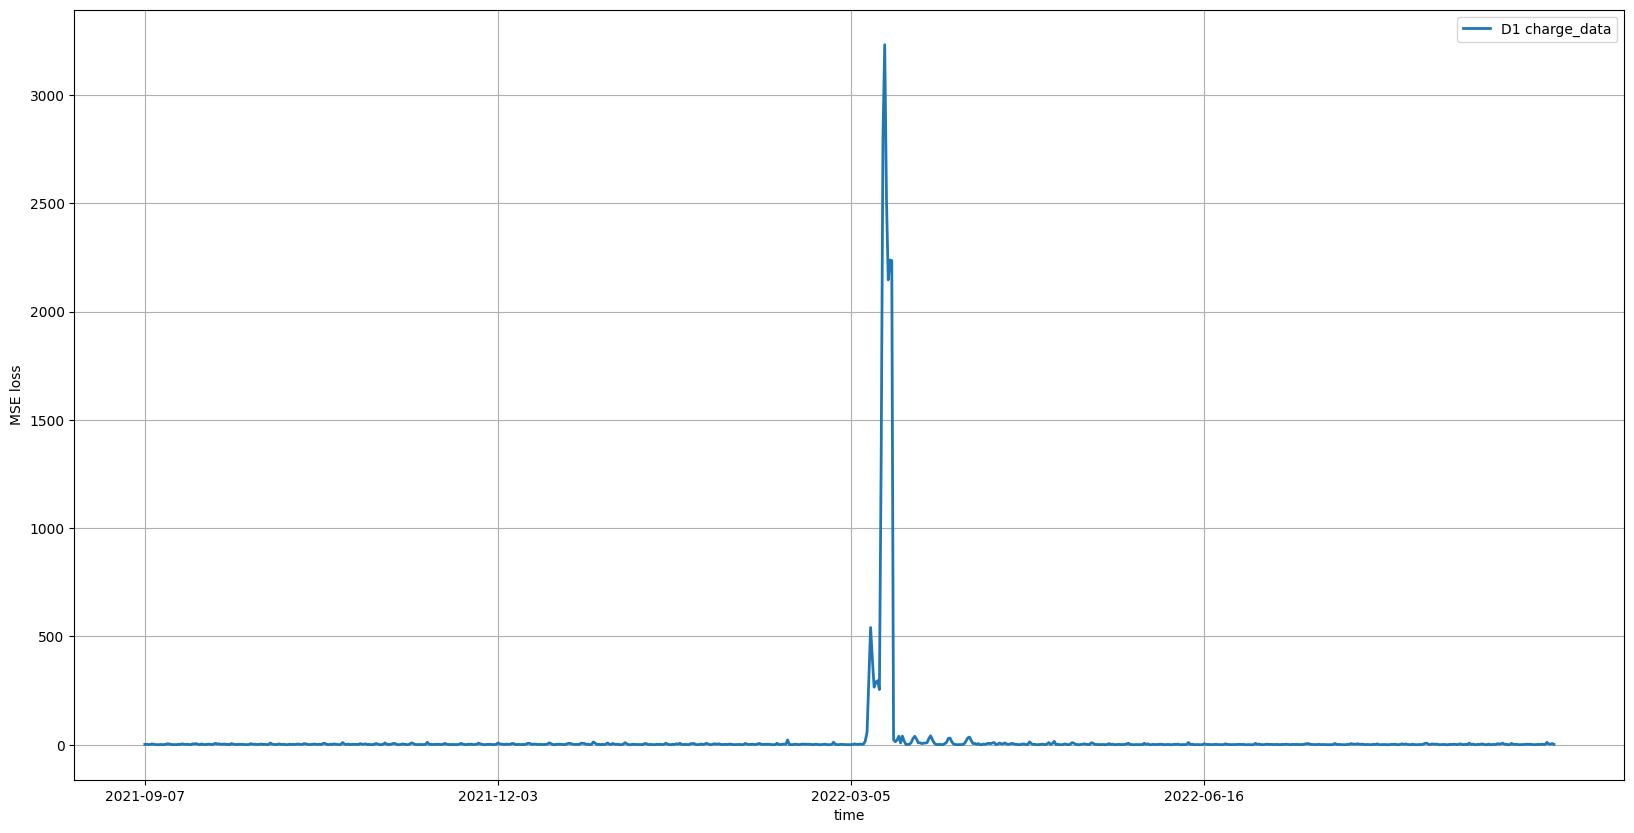

<Figure size 640x480 with 0 Axes>

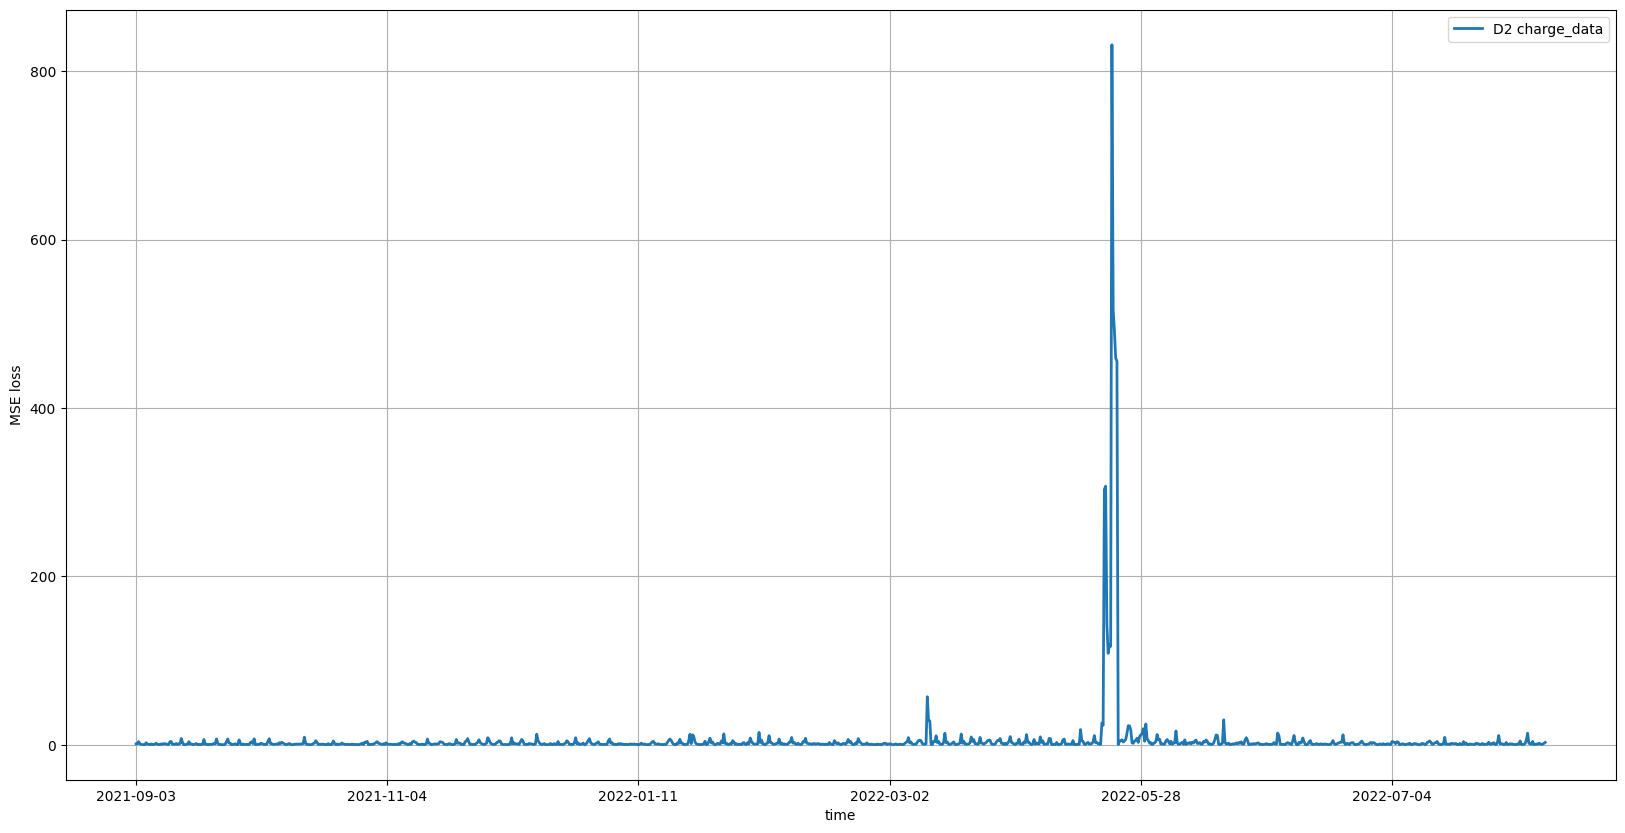

<Figure size 640x480 with 0 Axes>

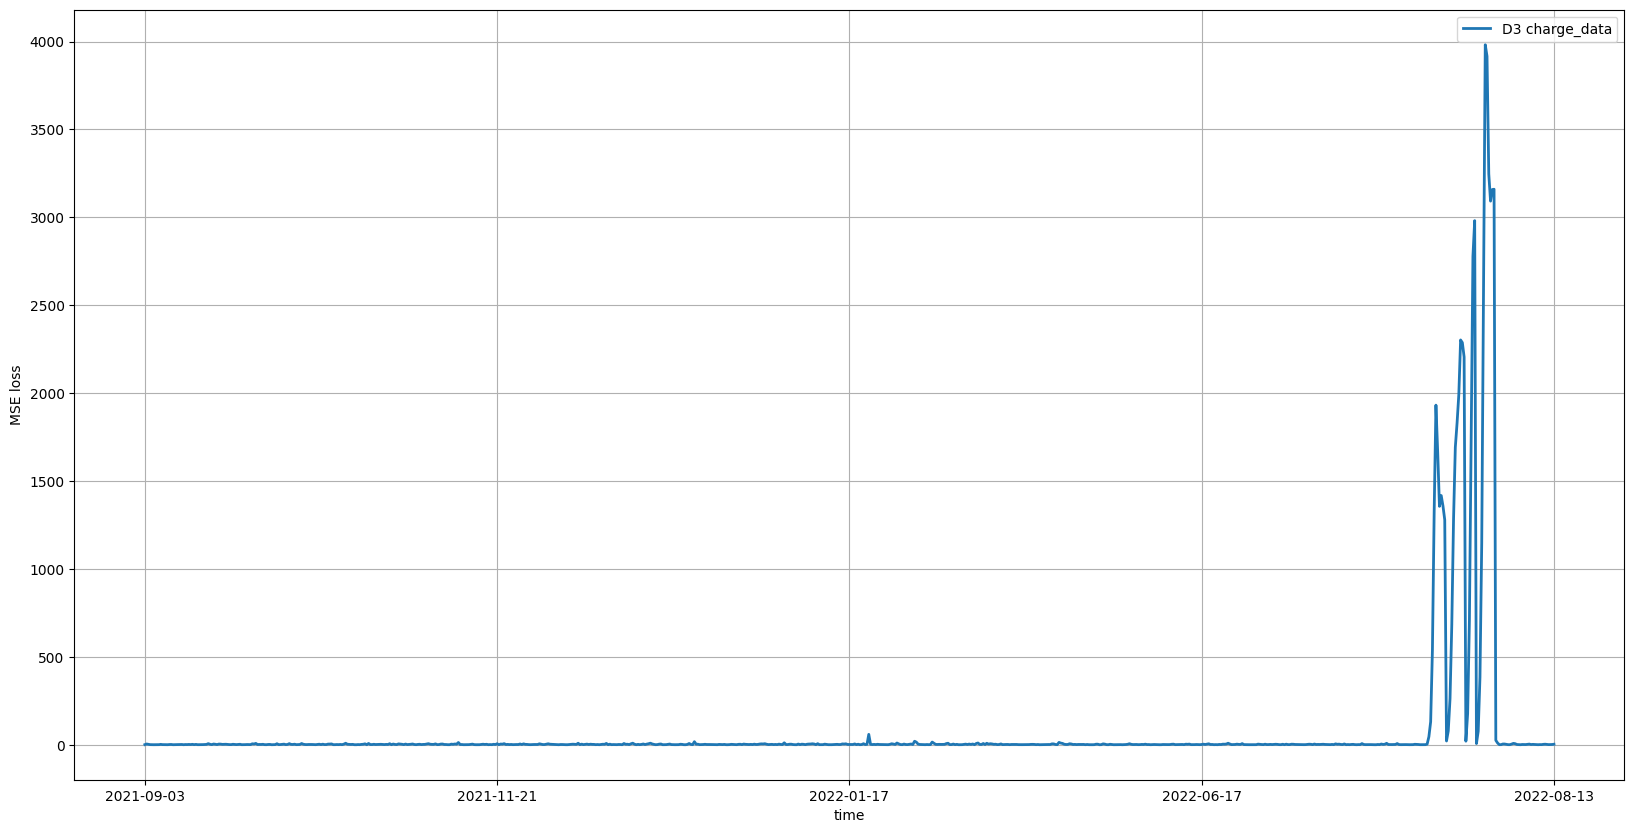

<Figure size 640x480 with 0 Axes>

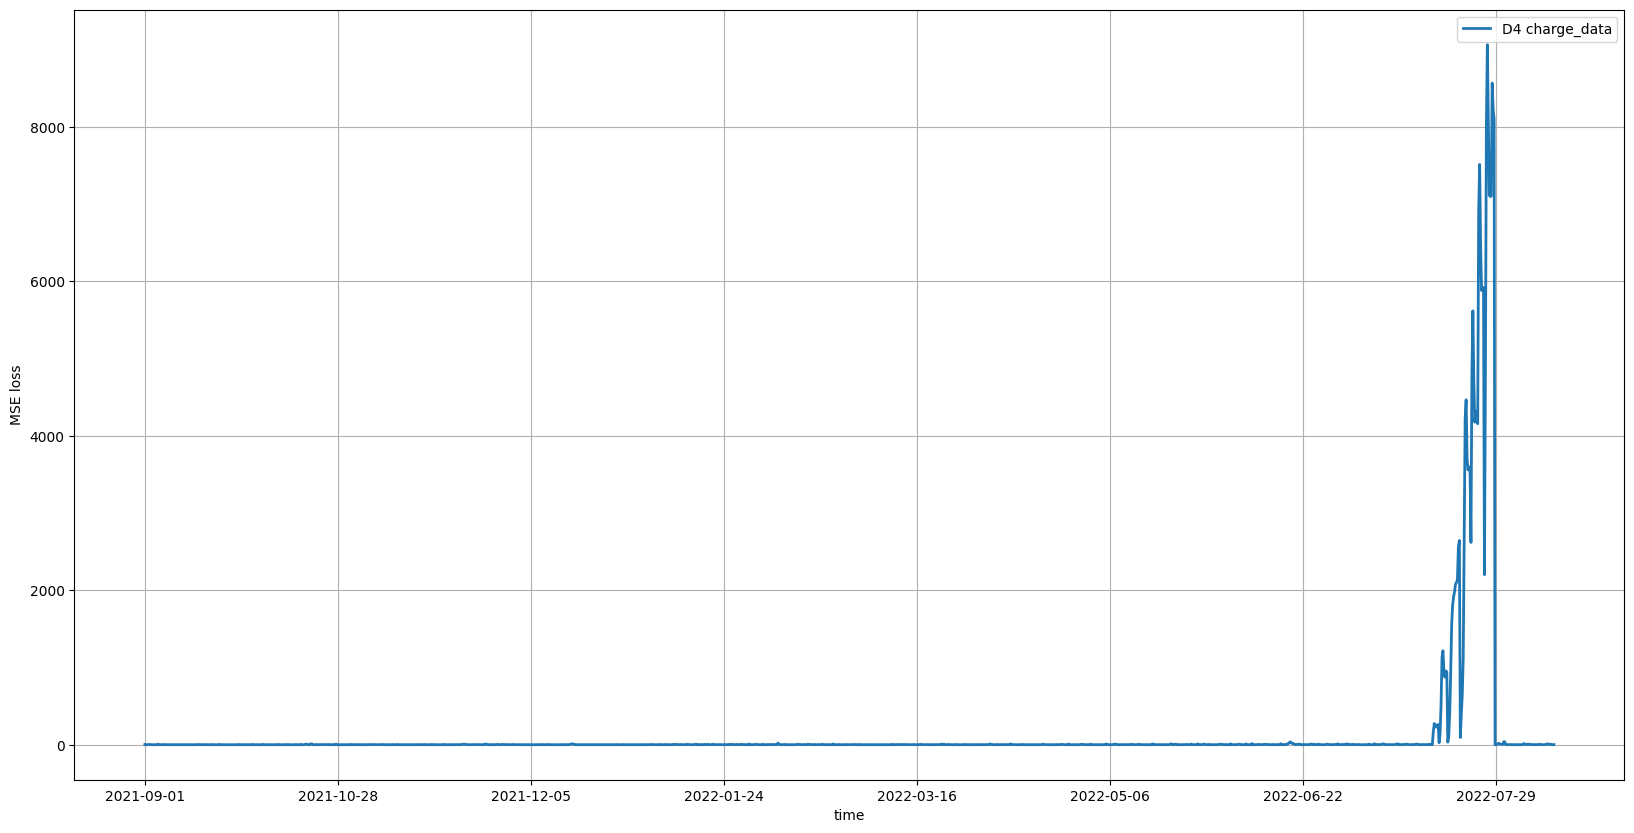

<Figure size 640x480 with 0 Axes>

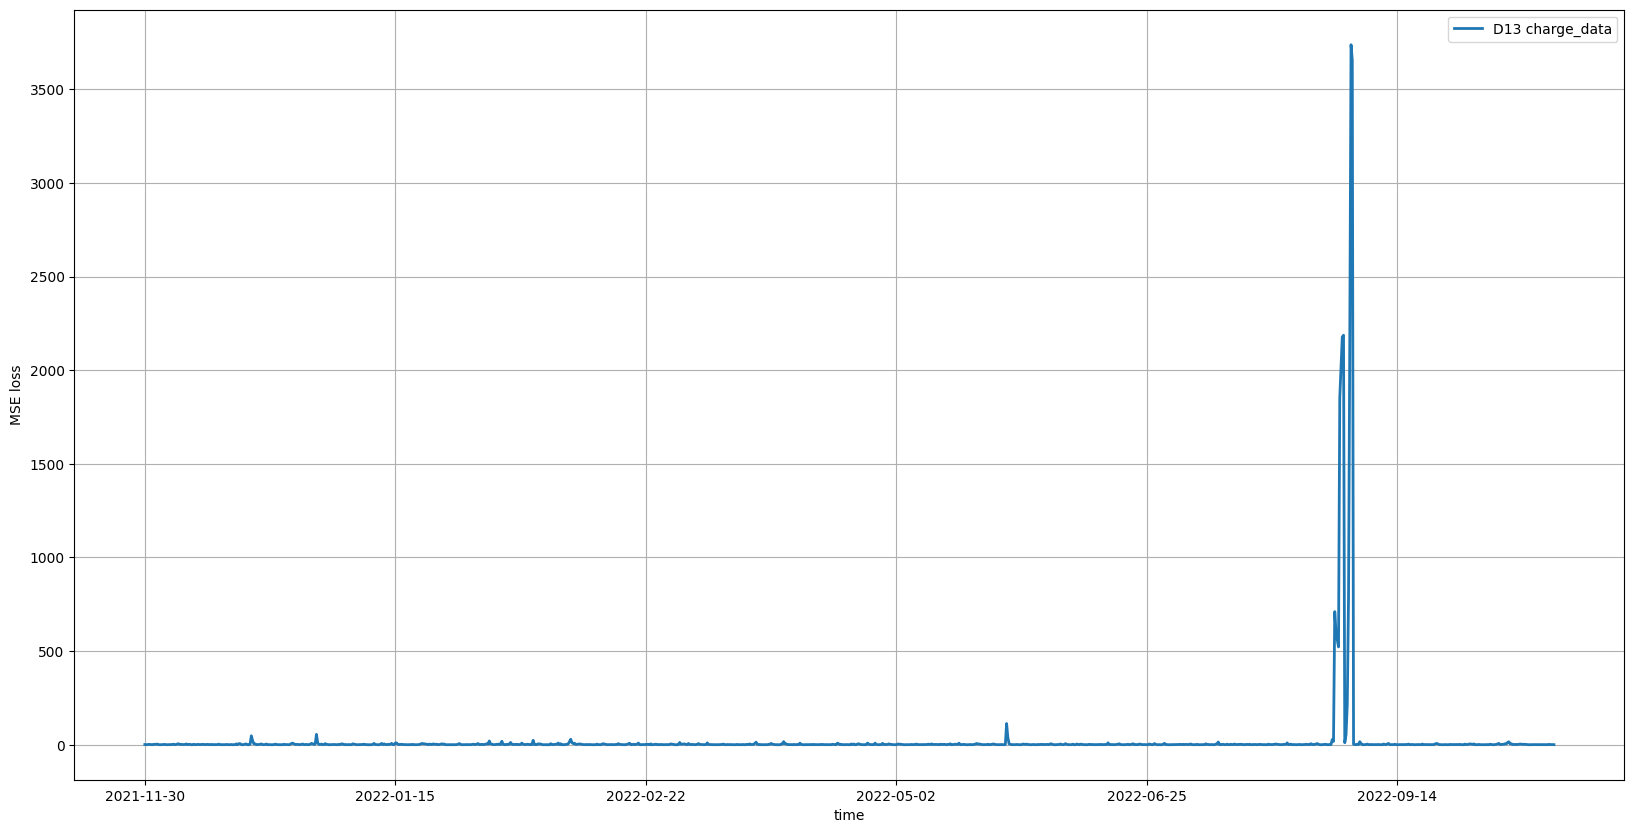

<Figure size 640x480 with 0 Axes>

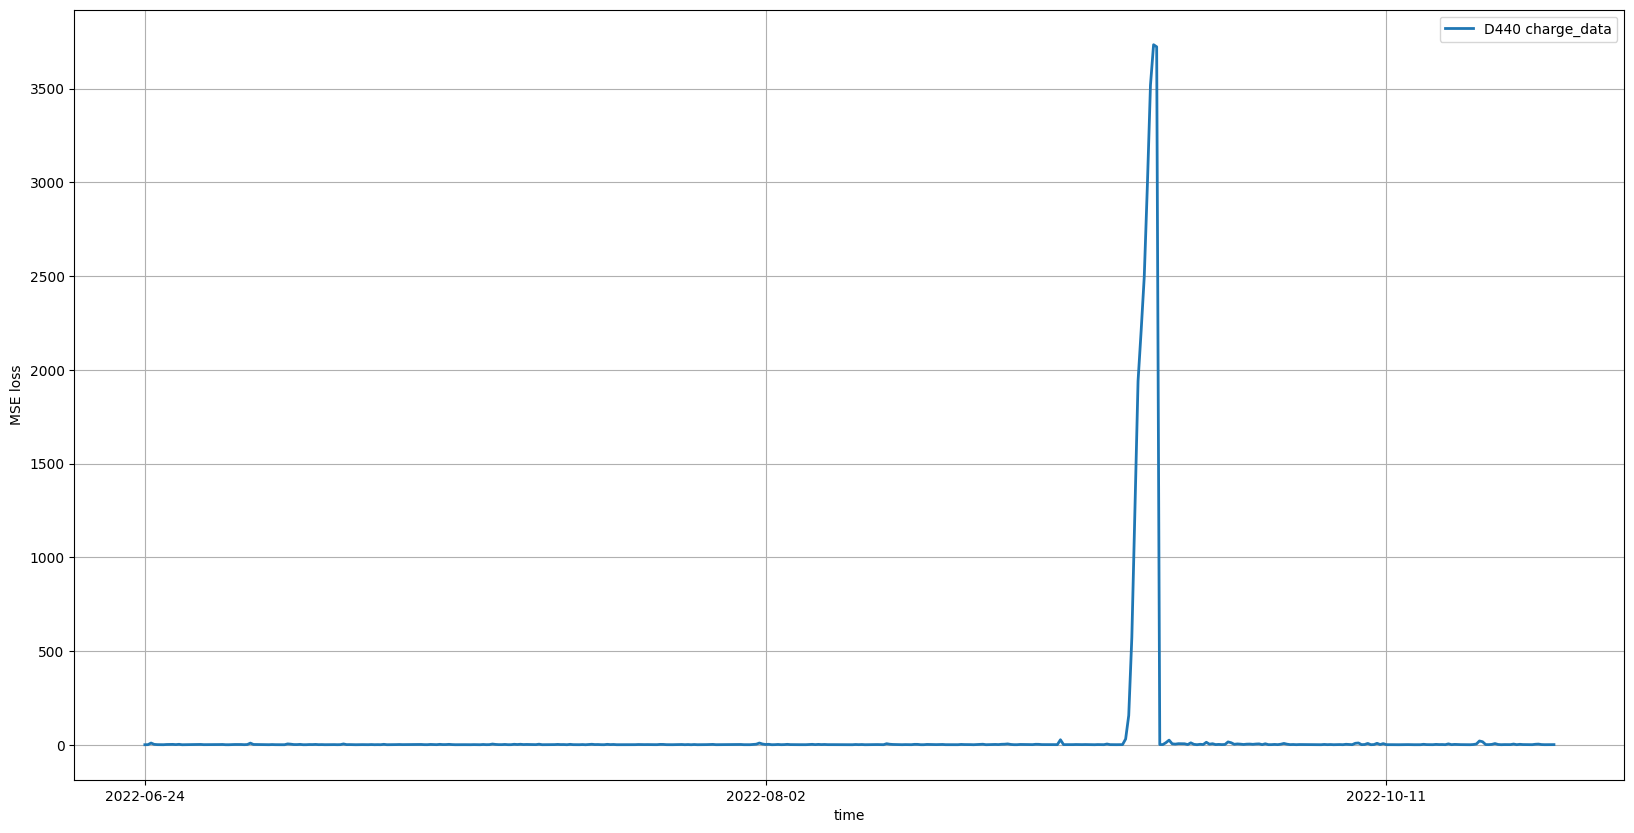

<Figure size 640x480 with 0 Axes>

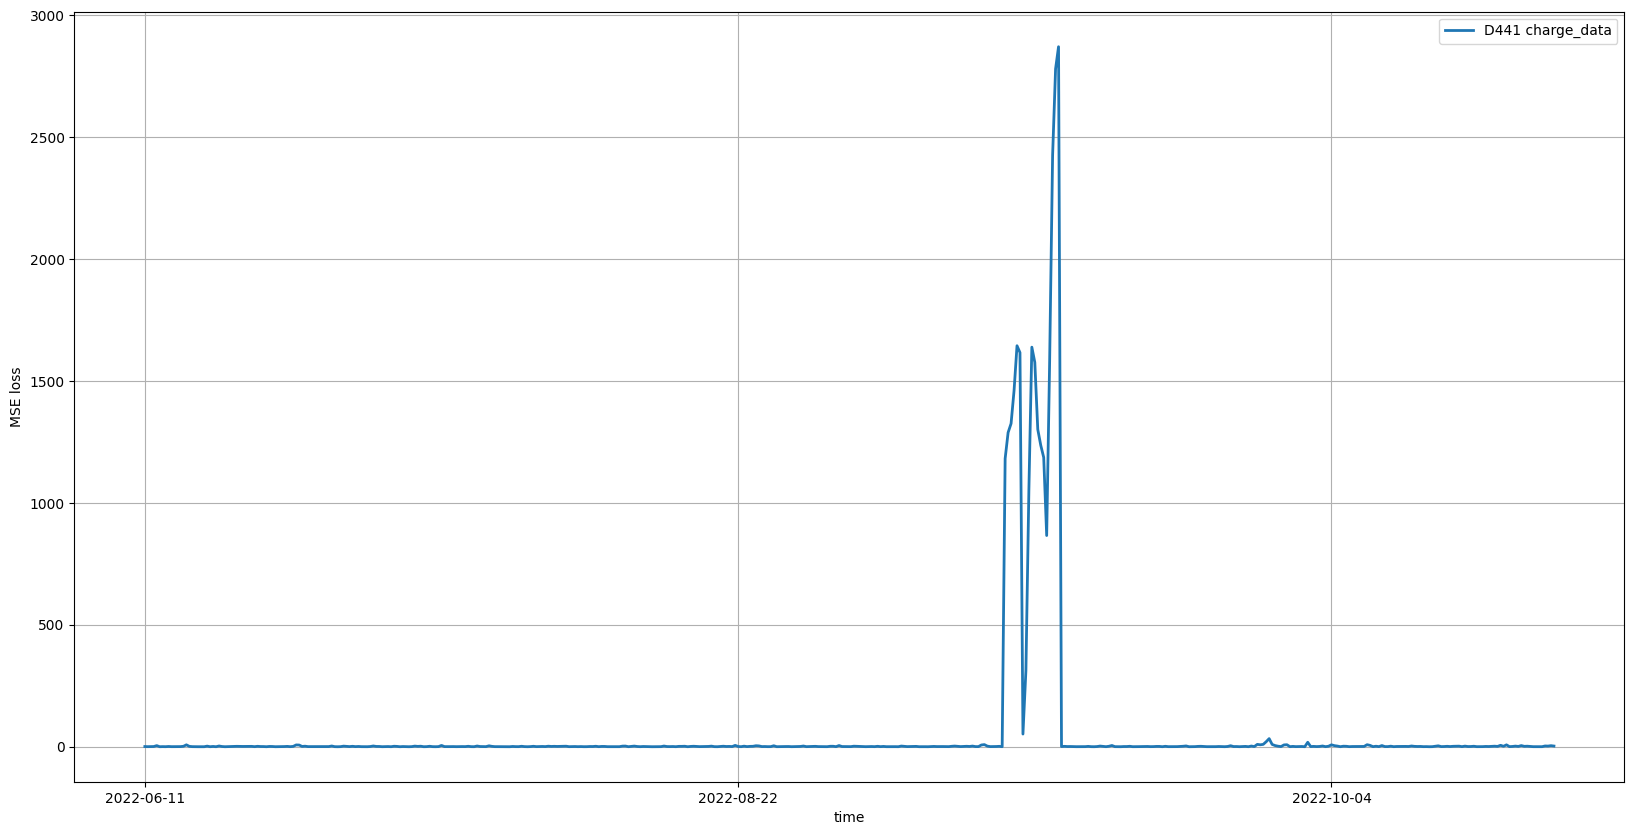

<Figure size 640x480 with 0 Axes>

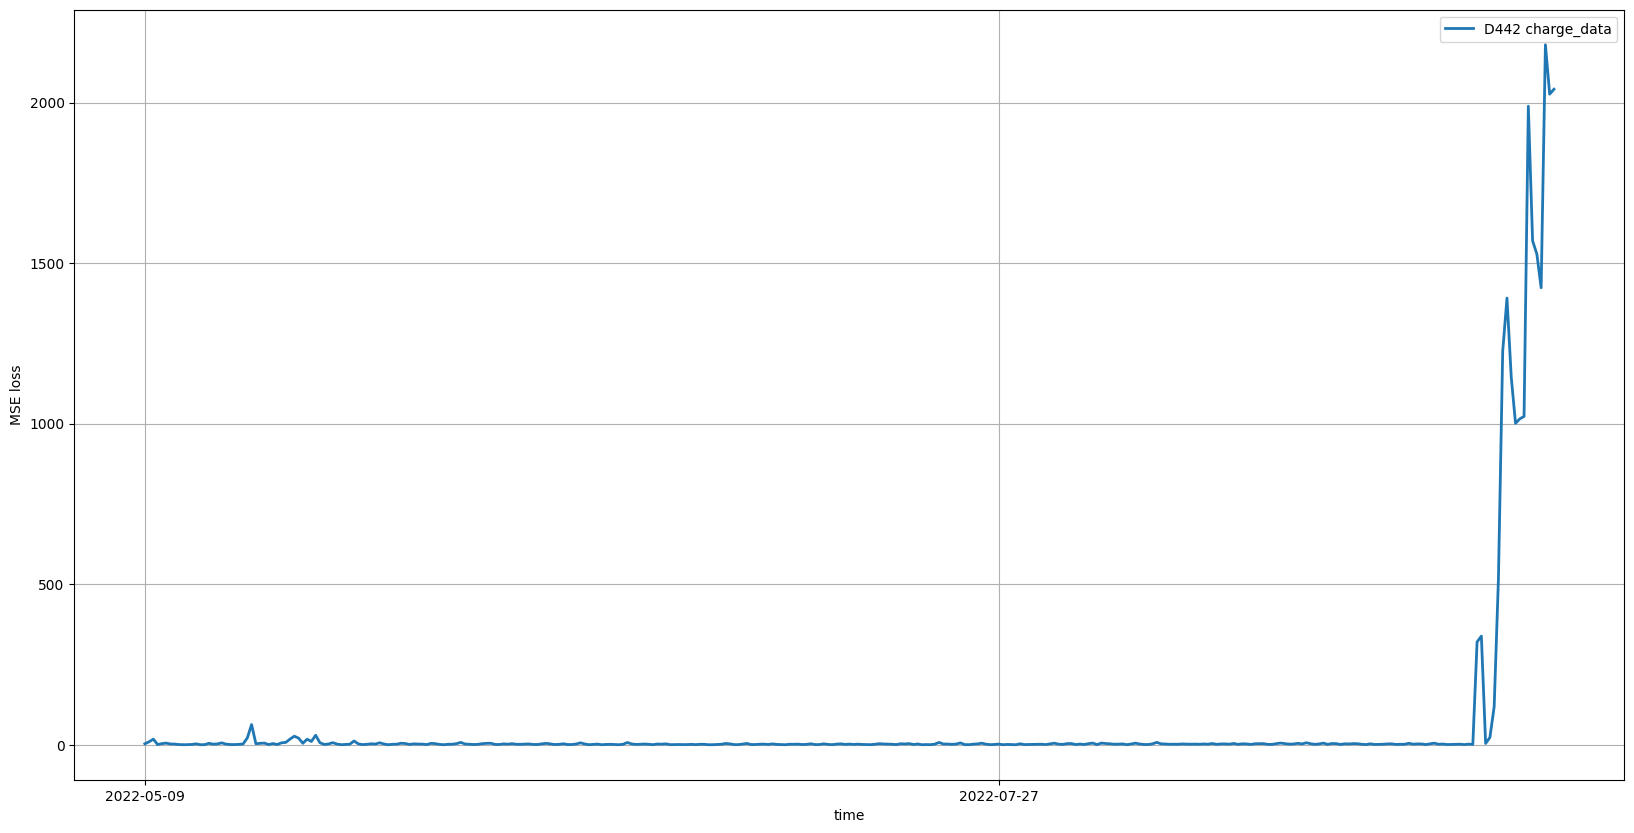

<Figure size 640x480 with 0 Axes>

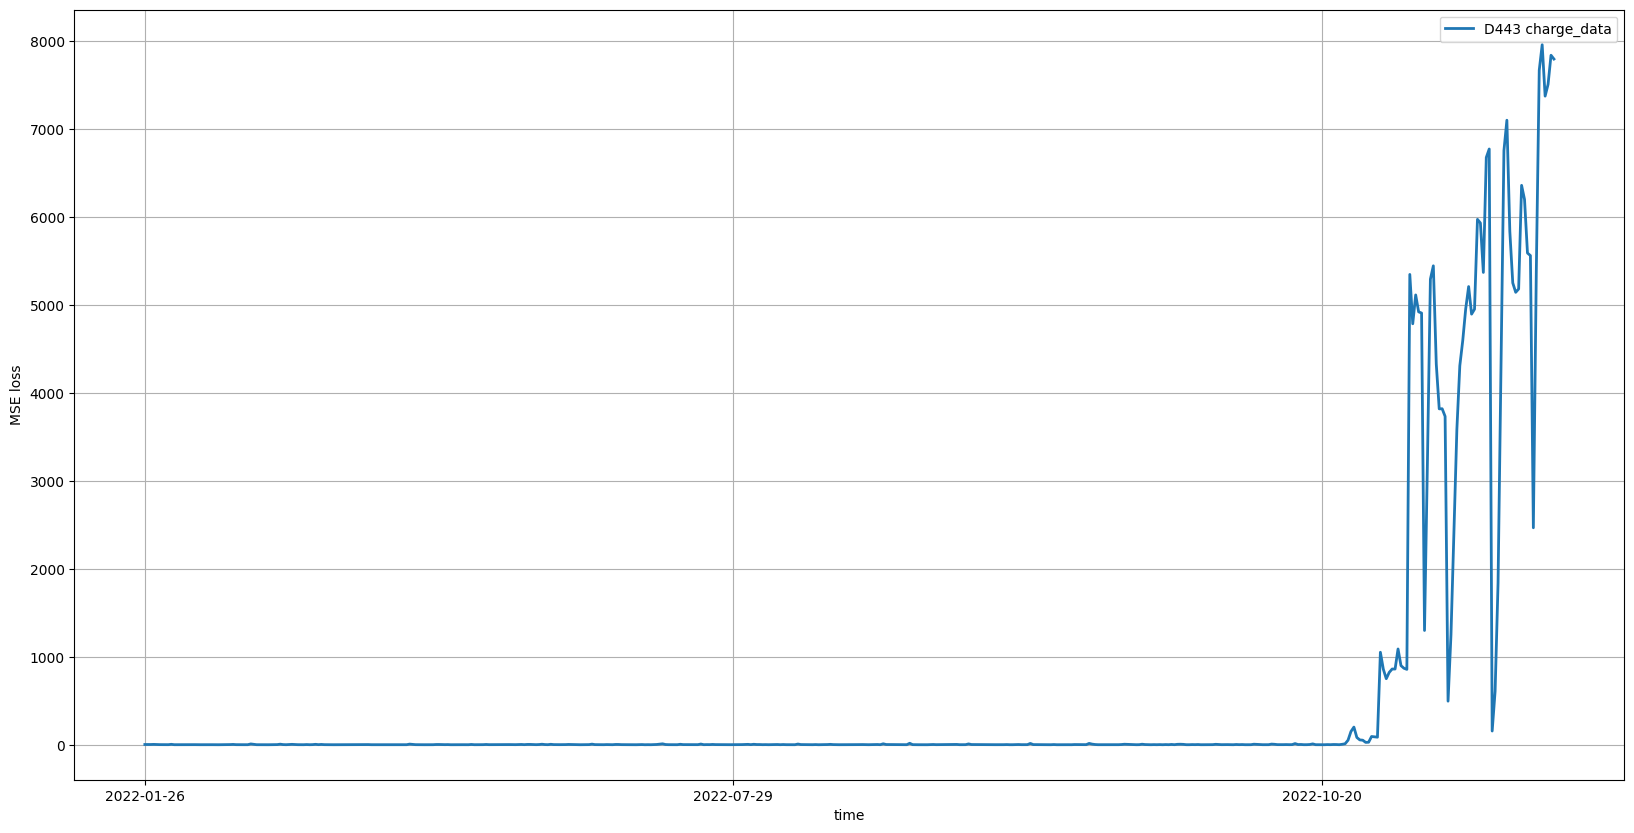

<Figure size 640x480 with 0 Axes>

In [358]:
for car in car_name:
    plot_abnormal_score_trend(loss_file, car)

In [385]:
tmp = pd.DataFrame(loss_file['D13_4_5'])
tmp=tmp.sort_values(by='samplingtimesec').reset_index(drop=True)
format_time(tmp['samplingtimesec'][tmp[tmp.loss>500].index.min()])

'2022-08-04 01:00:36'

In [311]:
np.save('result_plot/abnormal_cars_mse.npy', loss_file)

In [375]:
loss_fn = nn.MSELoss()
loss_fn = loss_fn.cuda()
loss_file = getTestResult('processed_data/normal_sample/charge_data',MyModel,loss_fn,dataProcess, final_cols)

processed_data/normal_sample/charge_data/D105_4_5.parquet
loss: 1.400447  [  101/  560]
loss: 6.882445  [  201/  560]
loss: 3.354408  [  301/  560]
loss: 0.263973  [  401/  560]
loss: 0.434896  [  501/  560]
processed_data/normal_sample/charge_data/D107_4_5.parquet
loss: 3.487663  [  601/  978]
loss: 0.766742  [  701/  978]
loss: 1.124225  [  801/  978]
loss: 0.621362  [  901/  978]
processed_data/normal_sample/charge_data/D131_4_5.parquet
loss: 0.464893  [ 1001/ 1433]
loss: 1.040509  [ 1101/ 1433]
loss: 0.419885  [ 1201/ 1433]
loss: 0.303647  [ 1301/ 1433]
loss: 3.780528  [ 1401/ 1433]
processed_data/normal_sample/charge_data/D162_4_5.parquet
loss: 0.211368  [ 1501/ 1671]
loss: 1.749189  [ 1601/ 1671]
processed_data/normal_sample/charge_data/D180_4_5.parquet
loss: 1.770752  [ 1701/ 2060]
loss: 4.509467  [ 1801/ 2060]
loss: 10.475454  [ 1901/ 2060]
loss: 1.632501  [ 2001/ 2060]
processed_data/normal_sample/charge_data/D246_4_5.parquet
loss: 1.763049  [ 2101/ 2737]
loss: 2.726721  [ 220

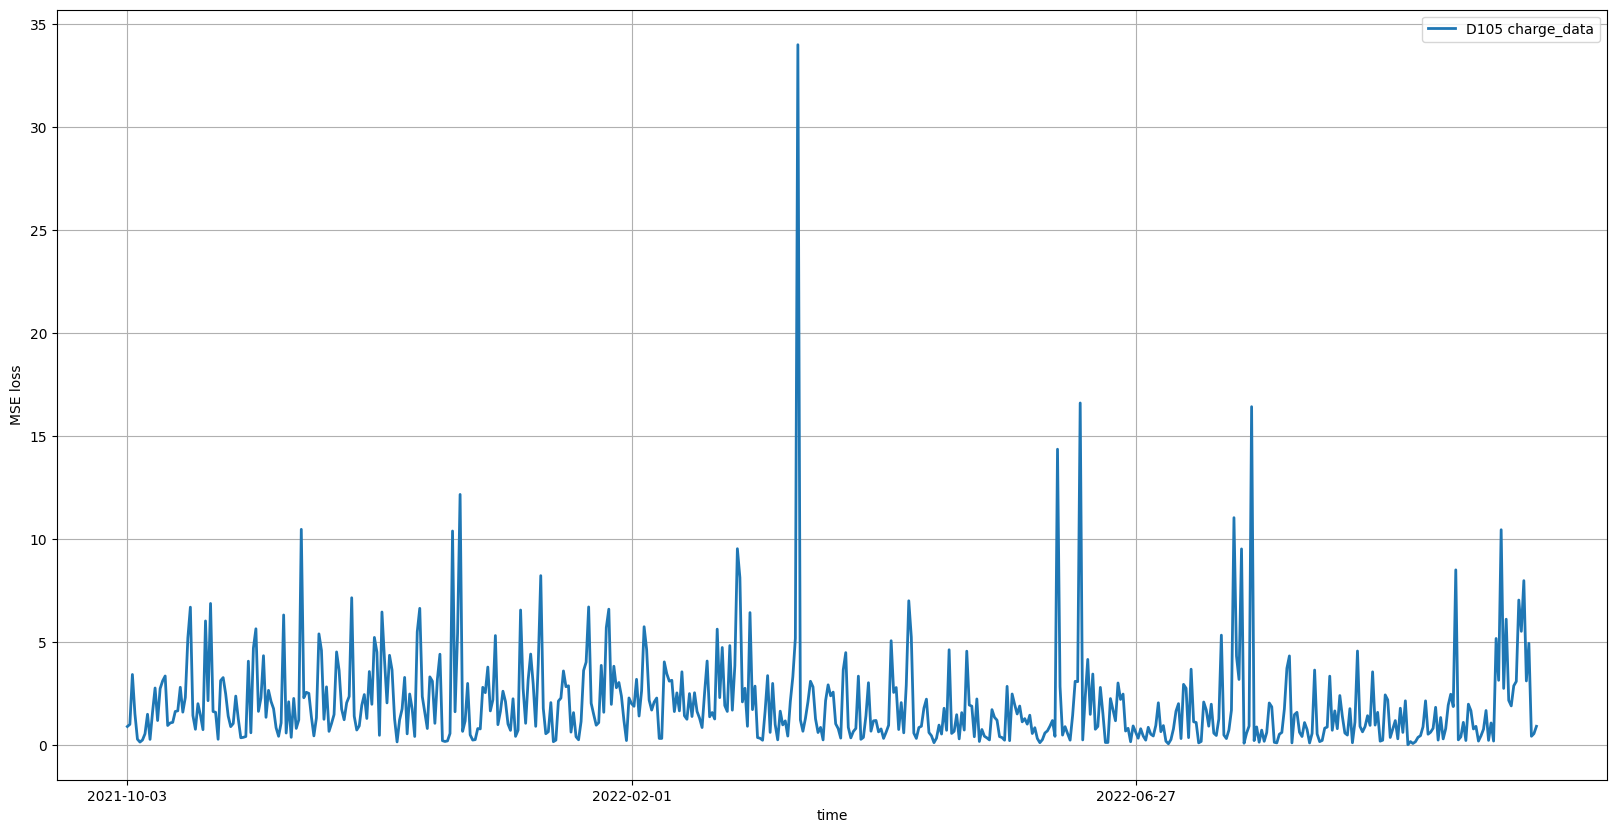

<Figure size 640x480 with 0 Axes>

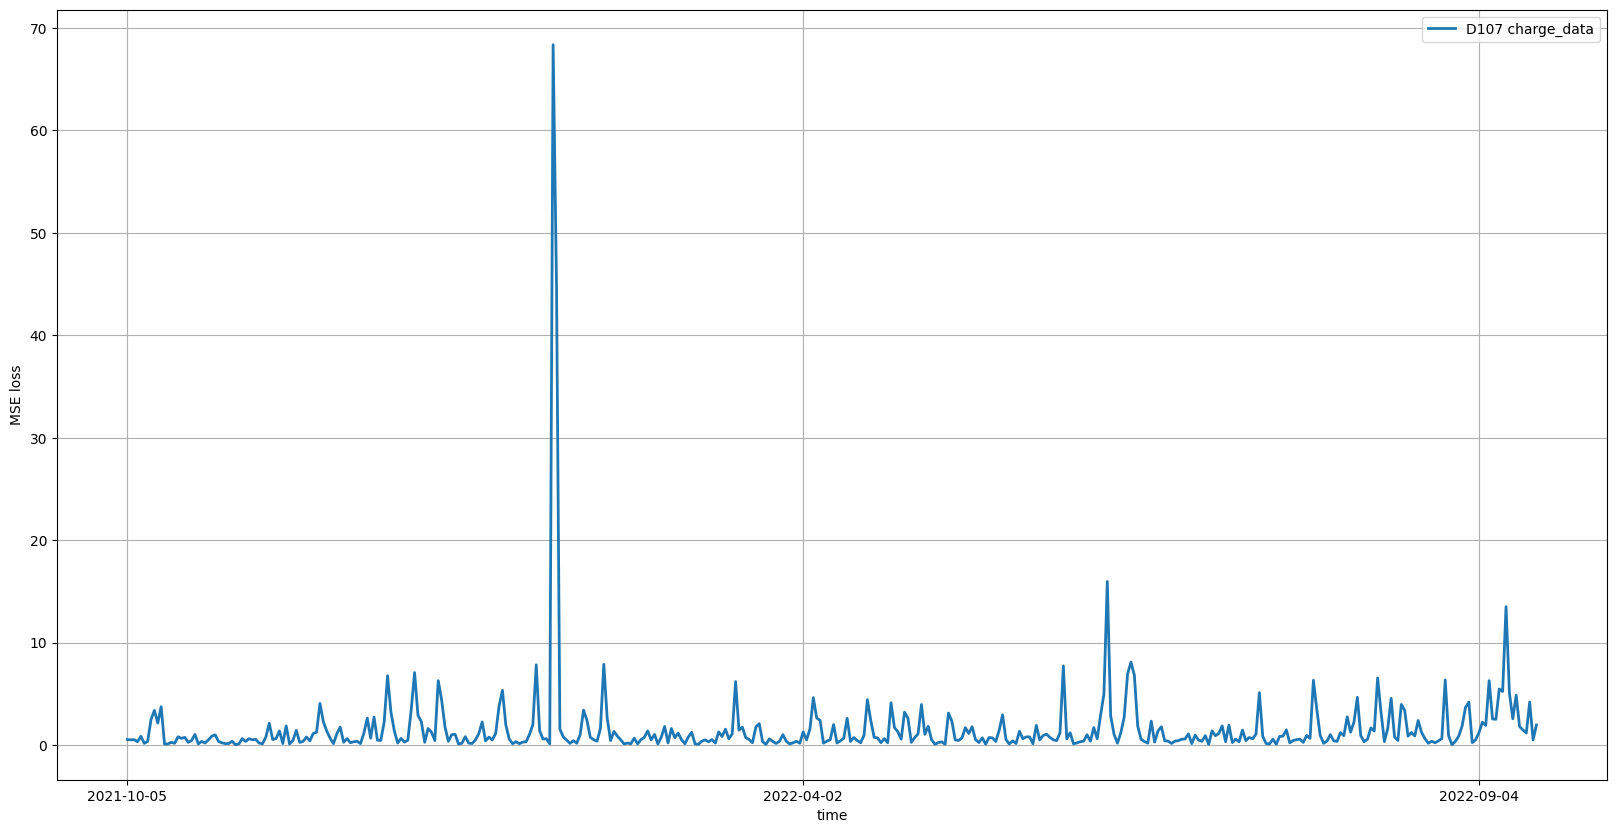

<Figure size 640x480 with 0 Axes>

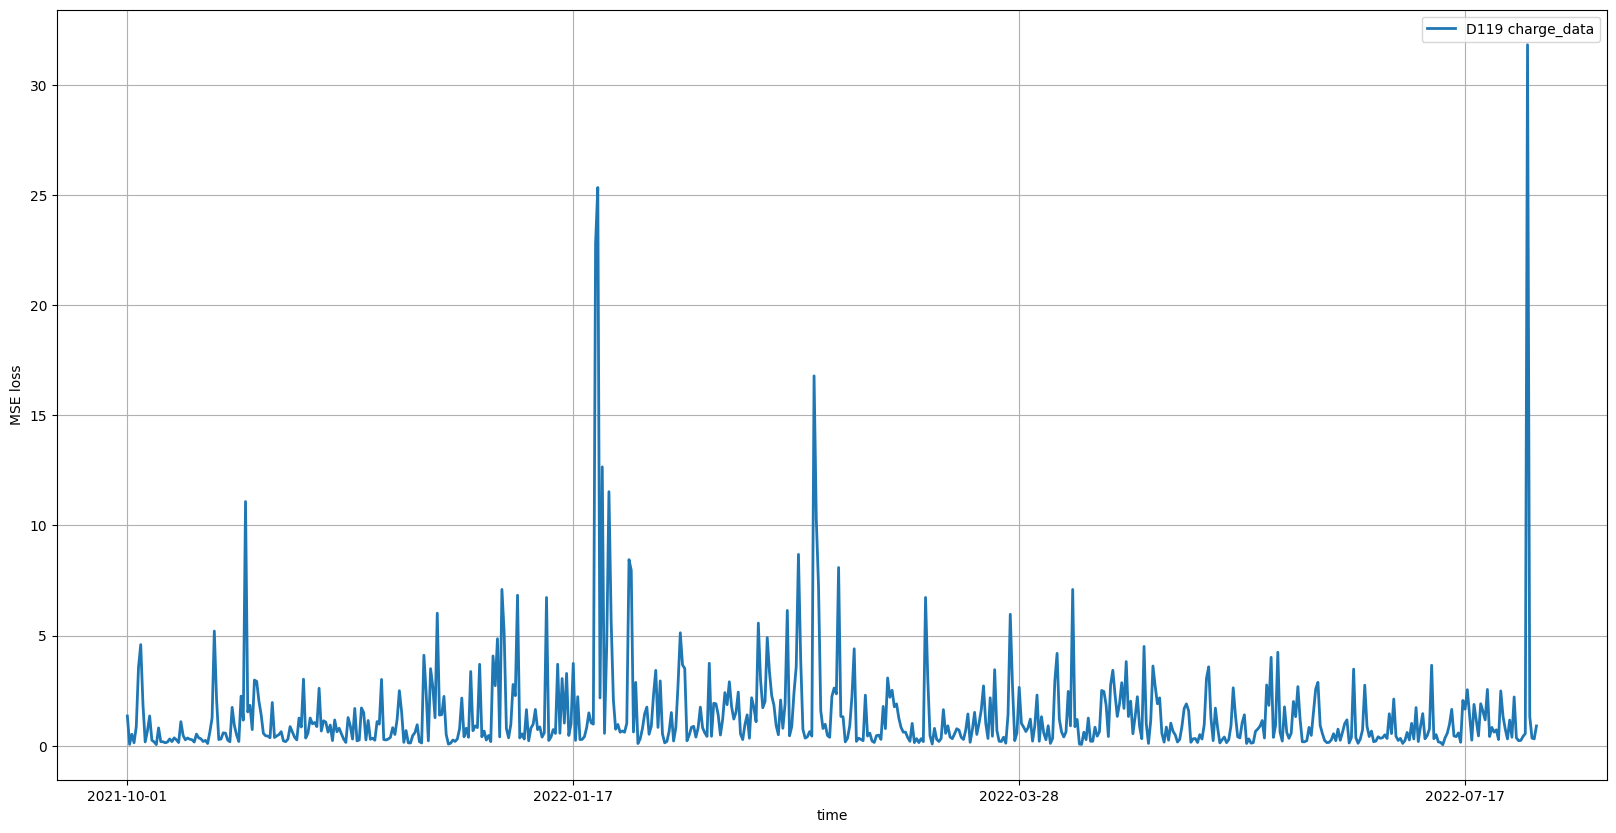

<Figure size 640x480 with 0 Axes>

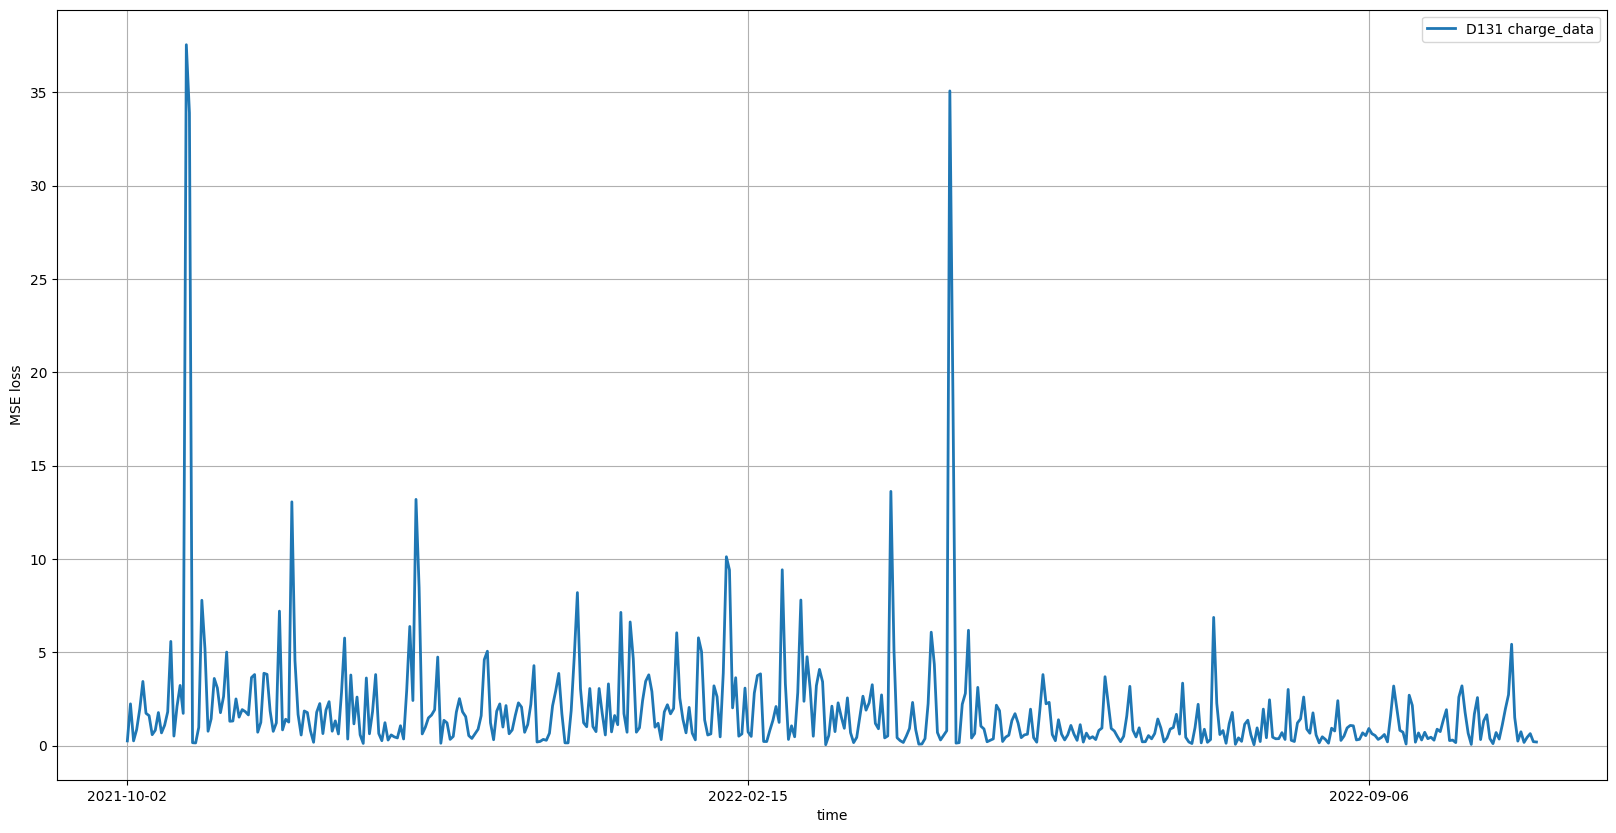

<Figure size 640x480 with 0 Axes>

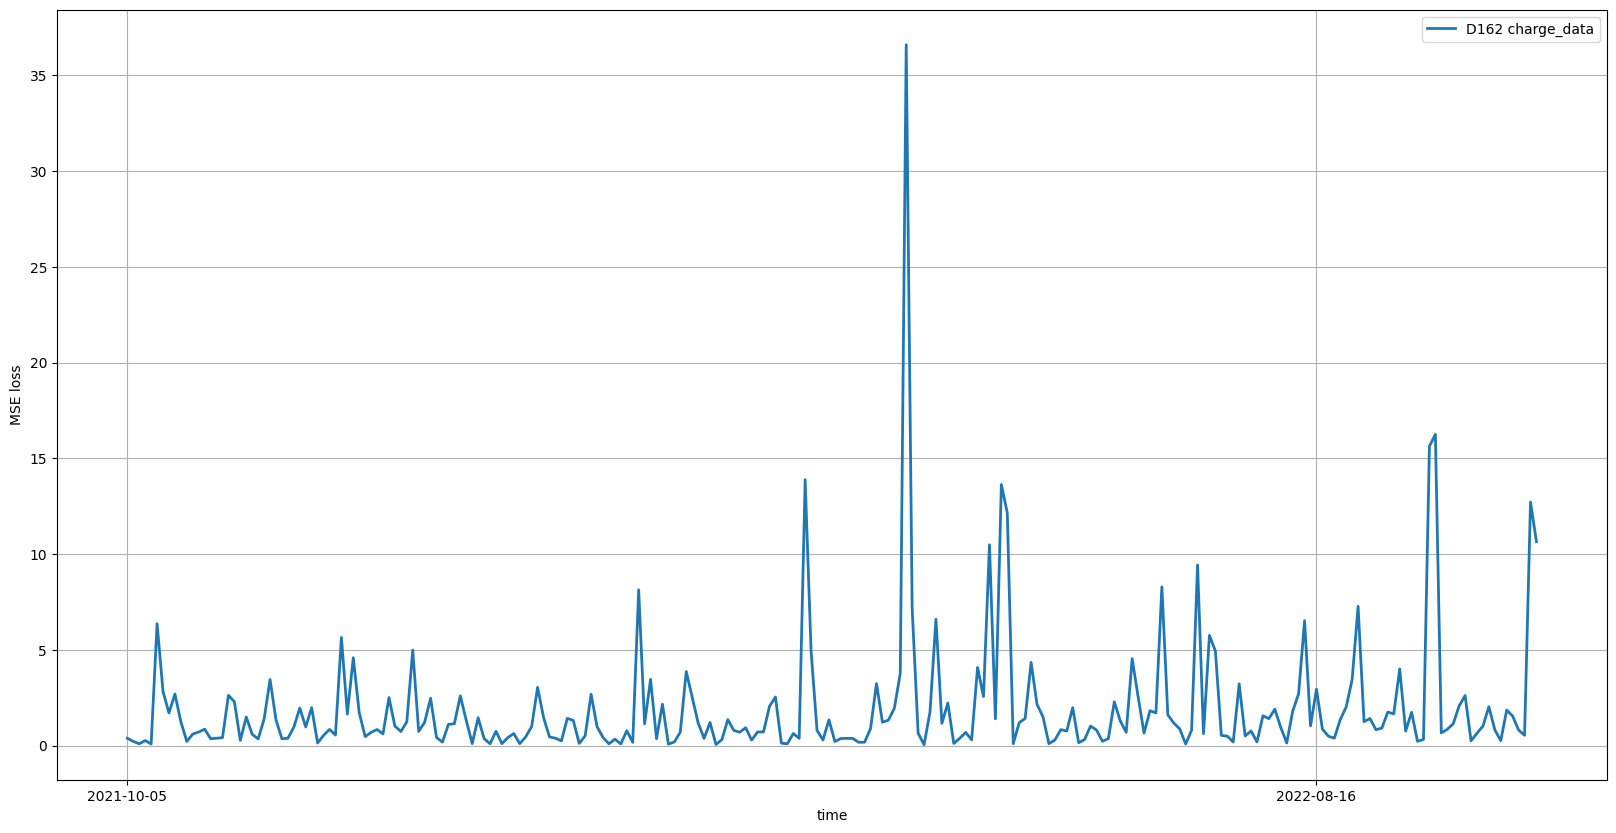

<Figure size 640x480 with 0 Axes>

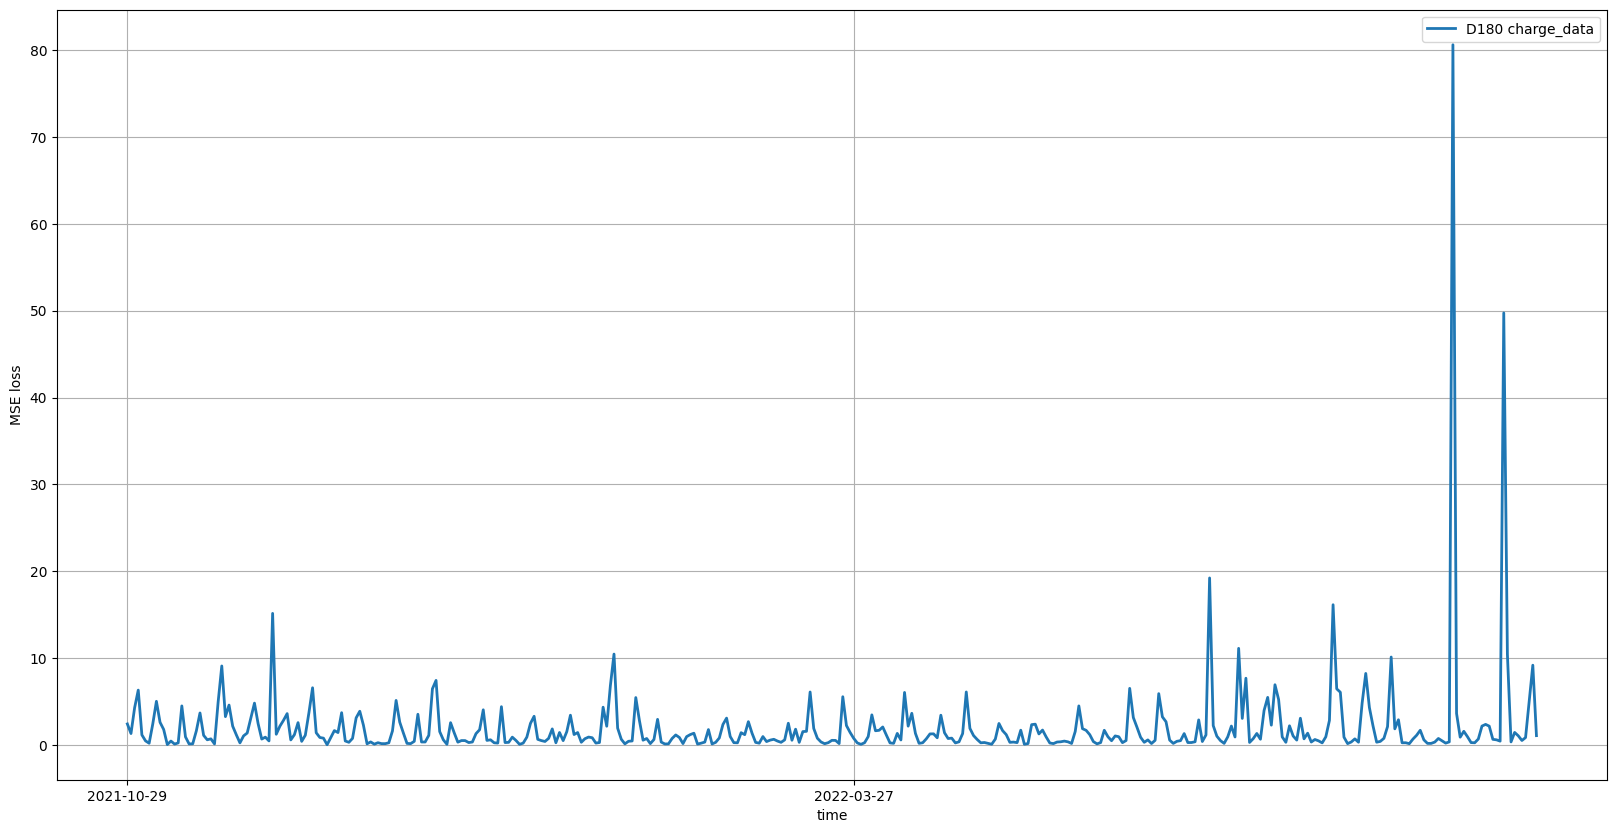

<Figure size 640x480 with 0 Axes>

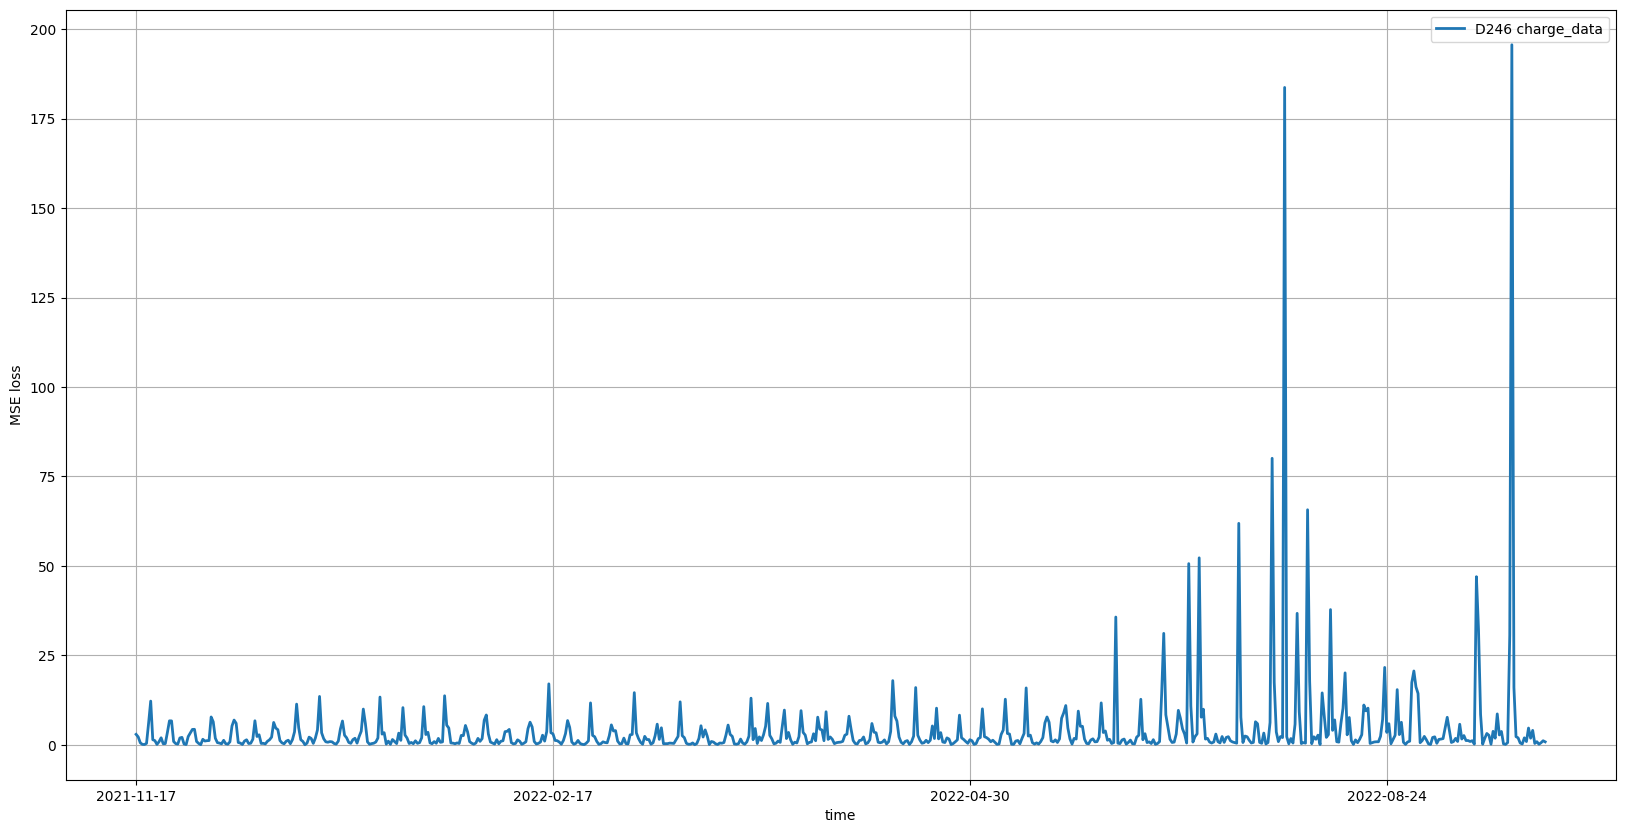

<Figure size 640x480 with 0 Axes>

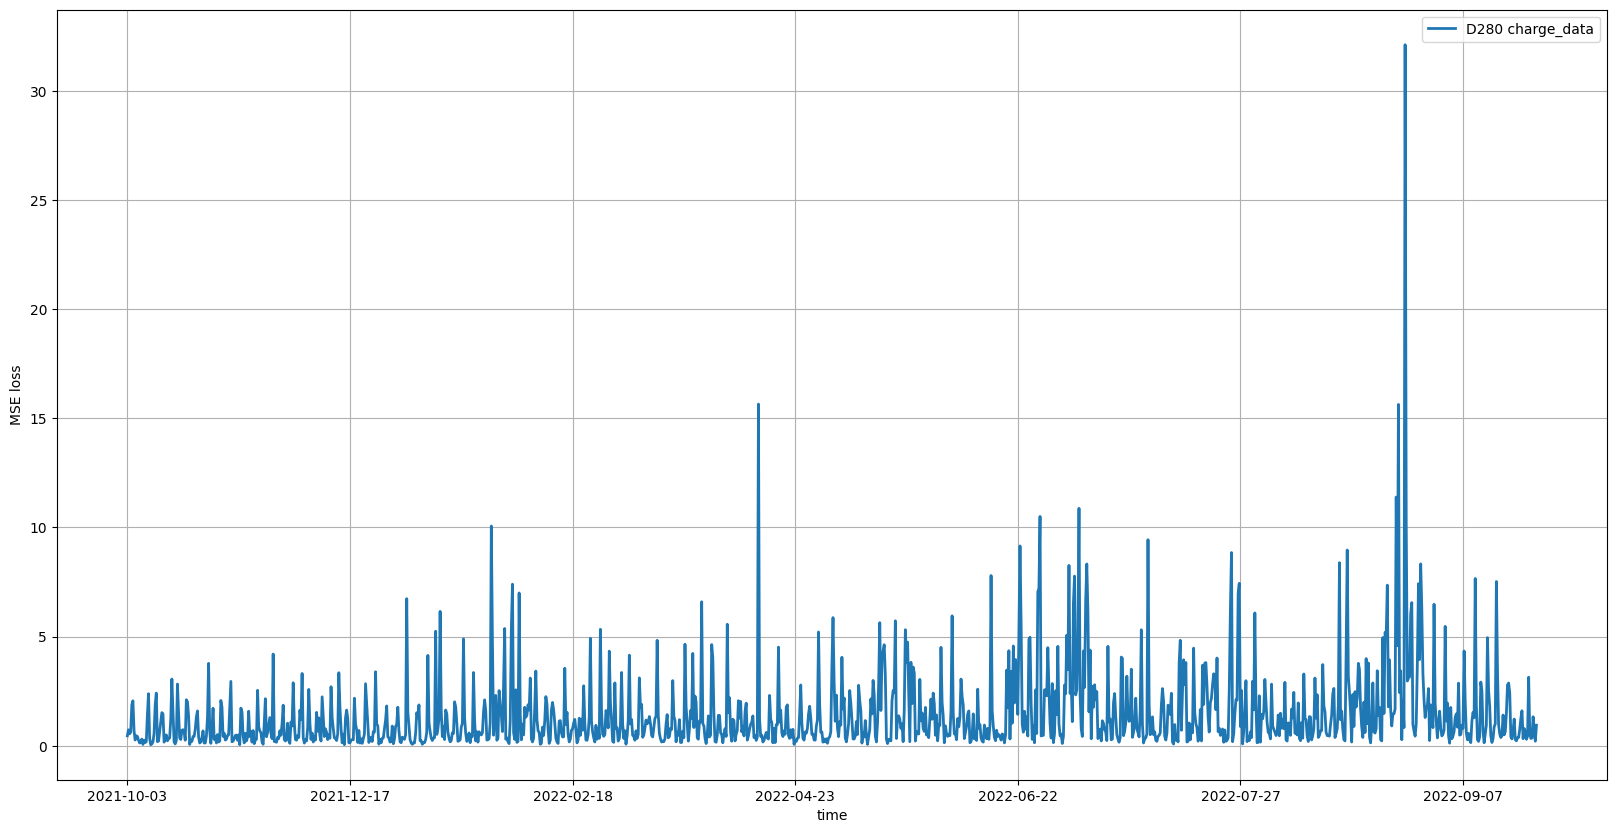

<Figure size 640x480 with 0 Axes>

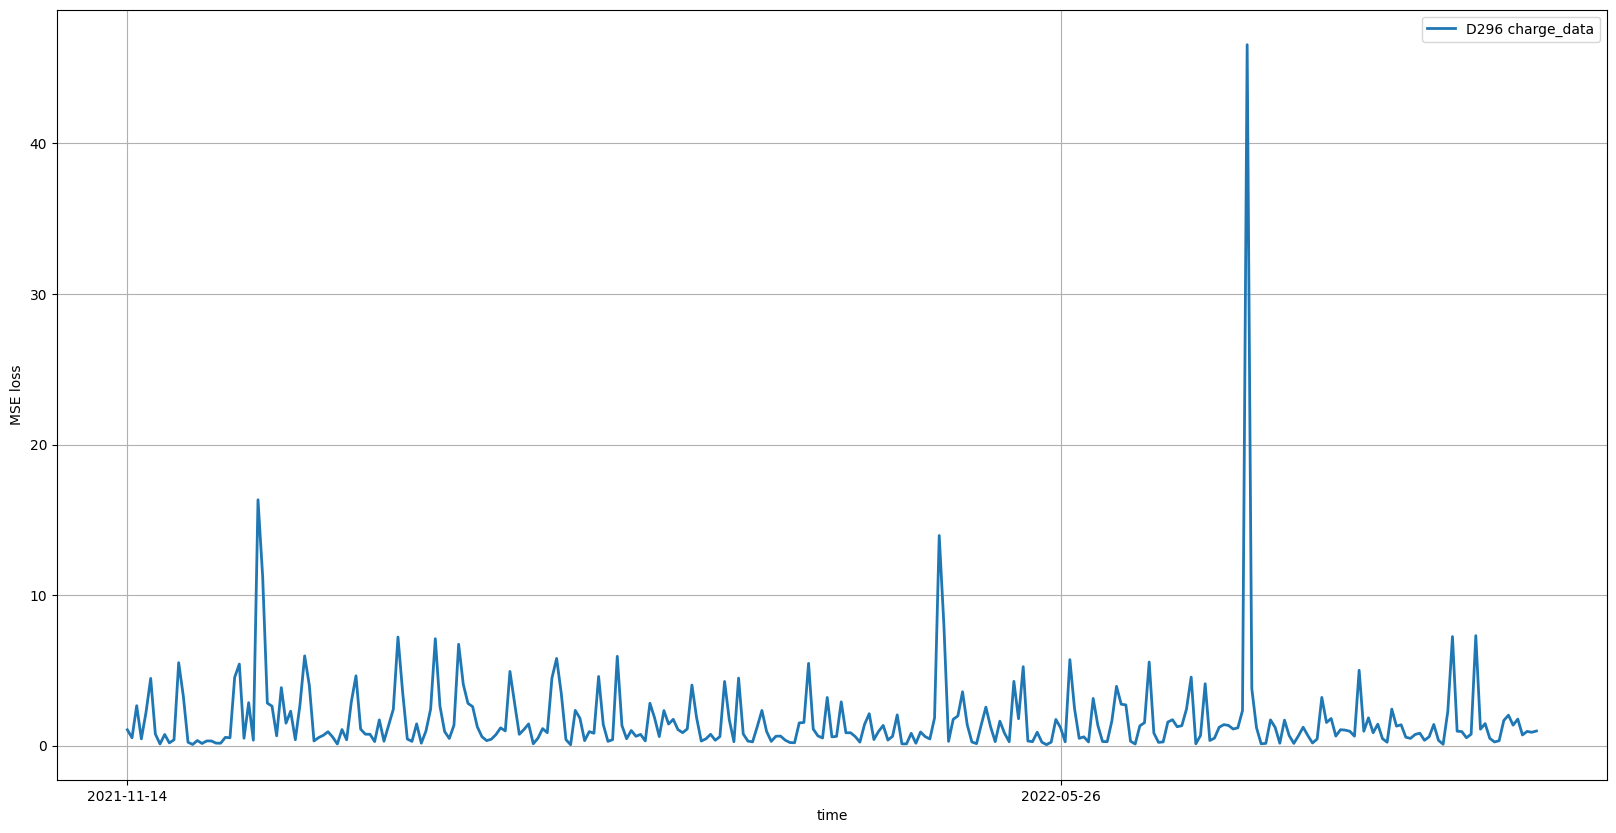

<Figure size 640x480 with 0 Axes>

In [376]:
car_name=['D105','D107','D119','D131','D162','D180','D246','D280','D296']
for car in car_name:
    plot_abnormal_score_trend(loss_file, car)

In [151]:
np.save('result_plot/normal_cars_mse.npy', loss_file)

## 训练放电的预测模型

In [212]:
model_dimension = 512
number_of_heads = 4
number_of_var = 114
number_of_layers = 3
dropout_probability = 0.4
hidden_dimension_list = [512,64,16,1]
d_hid = 512
in_channel = 10
out_channel = 10
kernel_size = 10
stride = 2

In [213]:
MyModel = DTN_model(model_dimension, number_of_heads, number_of_layers,d_hid, dropout_probability,
                    number_of_var, hidden_dimension_list, in_channel,out_channel,kernel_size,stride)

In [214]:
optimizer = Adam(MyModel.parameters(),lr=0.00001, betas=(0.9, 0.98), eps=1e-9)

In [215]:
MyModel = MyModel.cuda()
loss = nn.MSELoss()
loss=loss.cuda()

In [216]:
final_cols = [f"D135_{i}_dv" for i in range(1,113)]+['D135_diff_max','D135_std_max']+['cycle']

In [217]:
dataProcess = processor(['cycle'], 10, 2)

In [228]:
epochs = 160
batch_size=1
# all_losses=[]
for epoch in range(131,epochs+1):
    train_loss = train_loop('processed_data/normal_sample/discharge_data',MyModel,loss,optimizer, final_cols)
    all_losses.append(train_loss)
    if epoch % 10 == 0:
        torch.save({
                'epoch': epoch,
                'model_state_dict': MyModel.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, f"model/model_discharge_epoch{epoch}.pt")

processed_data/normal_sample/discharge_data/D105_3.parquet
loss: 2.855636  [  404/ 1273]
loss: 1.136040  [  804/ 1273]
loss: 7.971234  [ 1204/ 1273]
processed_data/normal_sample/discharge_data/D107_3.parquet
loss: 5.483869  [ 1604/ 2276]
loss: 4.131506  [ 2004/ 2276]
processed_data/normal_sample/discharge_data/D131_3.parquet
loss: 6.627414  [ 2404/ 3325]
loss: 1.587065  [ 2804/ 3325]
loss: 29.959538  [ 3204/ 3325]
processed_data/normal_sample/discharge_data/D162_3.parquet
loss: 1.789758  [ 3604/ 3975]
processed_data/normal_sample/discharge_data/D180_3.parquet
loss: 2.578439  [ 4004/ 4906]
loss: 5.078579  [ 4404/ 4906]
loss: 48.668713  [ 4804/ 4906]
processed_data/normal_sample/discharge_data/D246_3.parquet
loss: 2.979755  [ 5204/ 6768]
loss: 1.891914  [ 5604/ 6768]
loss: 2.475159  [ 6004/ 6768]
loss: 3.922829  [ 6404/ 6768]
processed_data/normal_sample/discharge_data/D280_3.parquet
loss: 7.075687  [ 6804/ 9813]
loss: 2.235142  [ 7204/ 9813]
loss: 8.285007  [ 7604/ 9813]
loss: 5.830071 

In [231]:
temp = pd.DataFrame({'epoch':[i for i in range(1,161)], 'total_loss':all_losses})
temp.to_csv('result_plot/discharge_model_losses.csv')

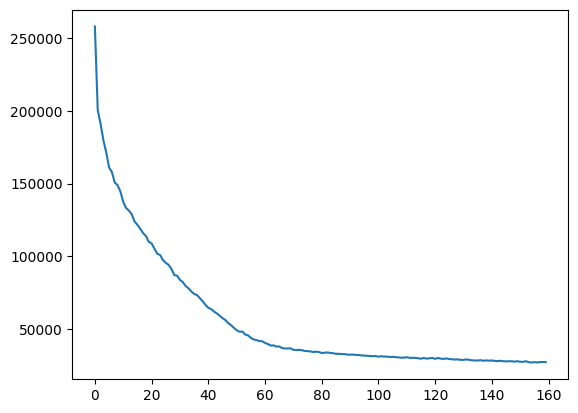

In [229]:
plt.plot(all_losses)
plt.show()

In [233]:
loss_fn = nn.MSELoss()
loss_fn = loss_fn.cuda()
dataProcess = processor2(['cycle'], 10, 2)
final_cols = [f"D135_{i}_dv" for i in range(1,113)]+['D135_diff_max','D135_std_max']+['cycle','samplingtimesec']
loss_file = getTestResult('processed_data/neg_sample/discharge_data',MyModel,loss_fn,dataProcess, final_cols)

processed_data/neg_sample/discharge_data/D1_3.parquet
loss: 1.997199  [  101/ 1935]
loss: 5.887031  [  201/ 1935]
loss: 8.801933  [  301/ 1935]
loss: 3.003928  [  401/ 1935]
loss: 0.830604  [  501/ 1935]
loss: 3.190149  [  601/ 1935]
loss: 27.656927  [  701/ 1935]
loss: 8.451325  [  801/ 1935]
loss: 119.397398  [  901/ 1935]
loss: 37.001229  [ 1001/ 1935]
loss: 3.577291  [ 1101/ 1935]
loss: 5.307461  [ 1201/ 1935]
loss: 15.875287  [ 1301/ 1935]
loss: 791.420548  [ 1401/ 1935]
loss: 1.654839  [ 1501/ 1935]
loss: 5.231758  [ 1601/ 1935]
loss: 2.351461  [ 1701/ 1935]
loss: 19.089978  [ 1801/ 1935]
loss: 16.842152  [ 1901/ 1935]
processed_data/neg_sample/discharge_data/D13_3.parquet
loss: 3.607313  [ 2001/ 4609]
loss: 2.981758  [ 2101/ 4609]
loss: 5.236376  [ 2201/ 4609]
loss: 1.872509  [ 2301/ 4609]
loss: 0.784717  [ 2401/ 4609]
loss: 2.798483  [ 2501/ 4609]
loss: 21.001557  [ 2601/ 4609]
loss: 15.153915  [ 2701/ 4609]
loss: 1.363977  [ 2801/ 4609]
loss: 2.230693  [ 2901/ 4609]
loss: 3.51

In [234]:
def plot_abnormal_score_trend(loss_file, car):
    res_file = loss_file[f"{car}_3"].copy()
    res_file['samplingtimesec'] = [format_time(x) for x in res_file['samplingtimesec']]
    n_len = len(res_file['loss'])
    df = pd.DataFrame({'samplingtimesec':res_file['samplingtimesec'], 'loss':res_file['loss']})
    df = df.sort_values(by='samplingtimesec').reset_index(drop=True)
    plt.figure(figsize=(20,10))
    idx_l = list(range(0, n_len))[::200]
    idx_r = [df['samplingtimesec'][x][:10] for x in idx_l]
    # idx_r = [str(x)[11:] for x in idx_r]
    plt.xticks(idx_l,idx_r)
    plt.xlabel('time')
    plt.ylabel('MSE loss')
    plt.plot(df['loss'],label=f"{car} discharge_data", linewidth=2)
    # plt.plot(tmp['D135_diff_y'],'--', label="smooth data", linewidth=4)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    plt.savefig(f"result_plot/{car}_discharge_mse.png")
    return

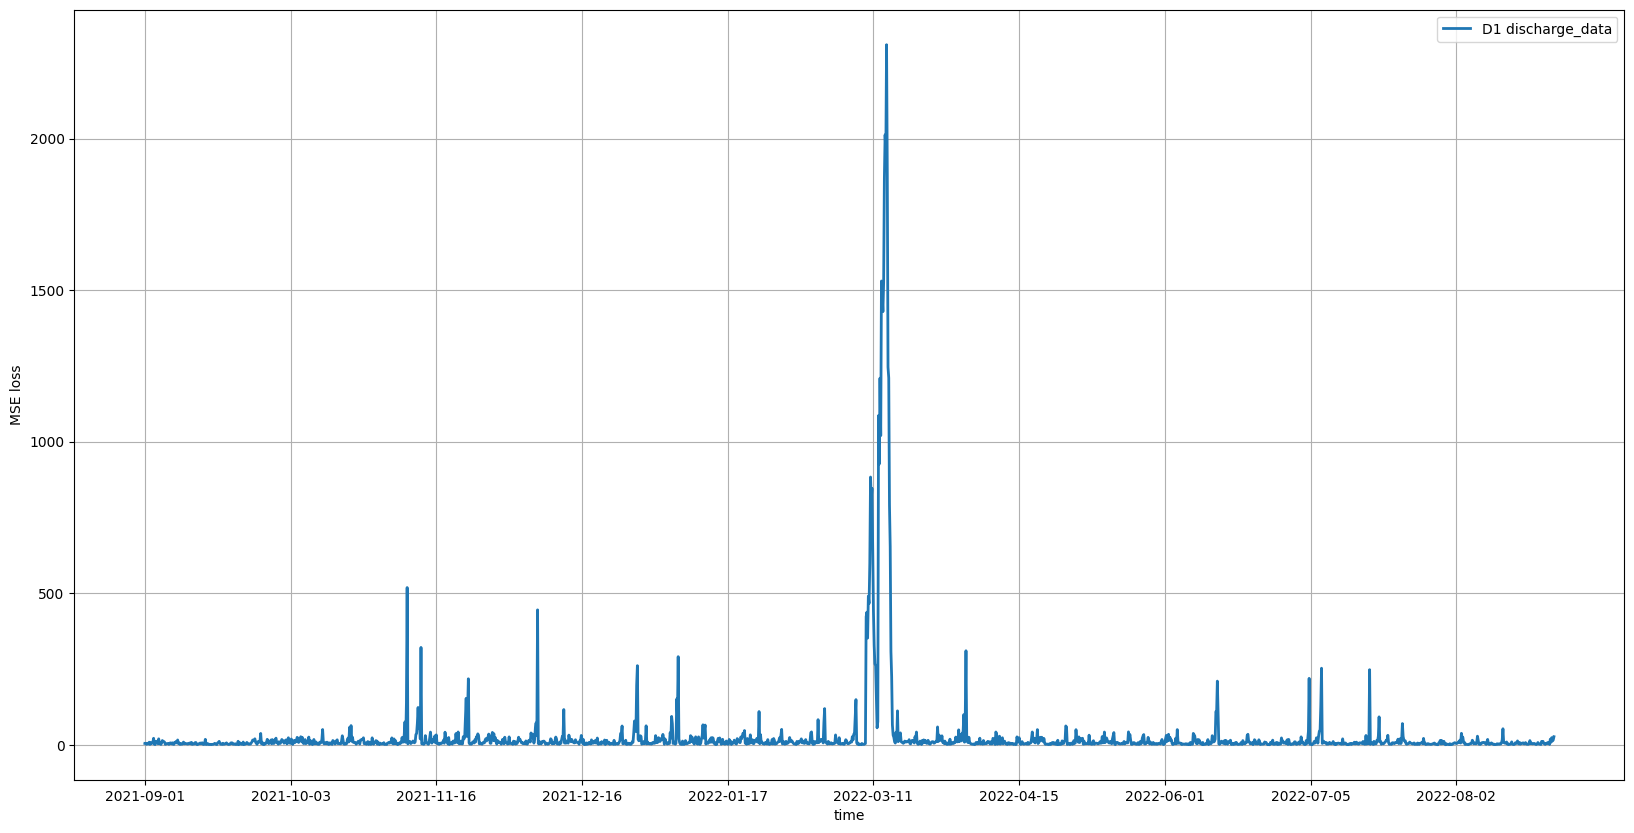

<Figure size 640x480 with 0 Axes>

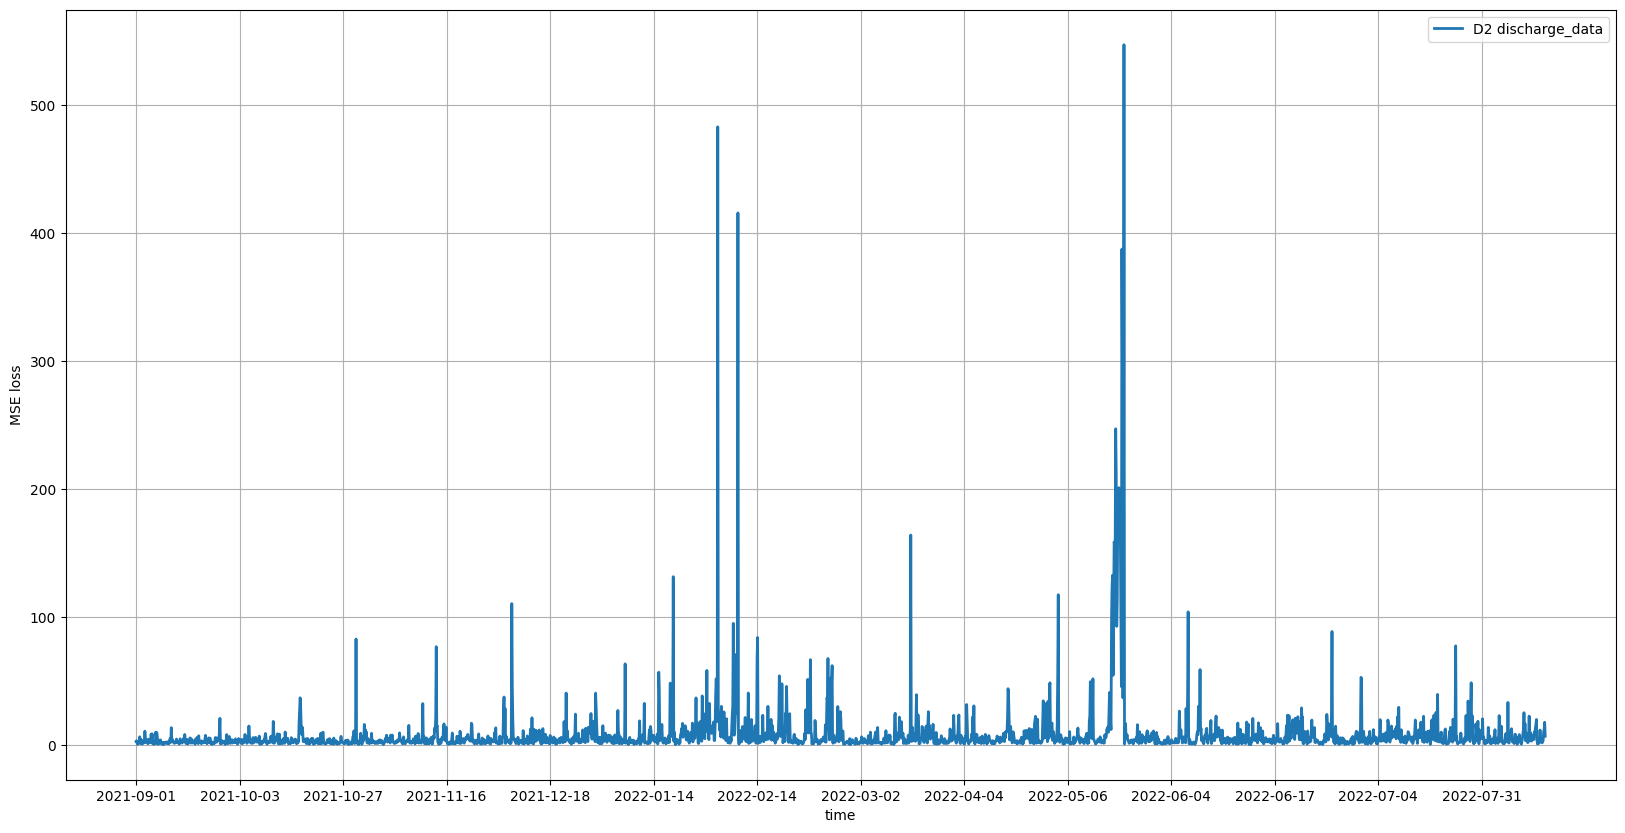

<Figure size 640x480 with 0 Axes>

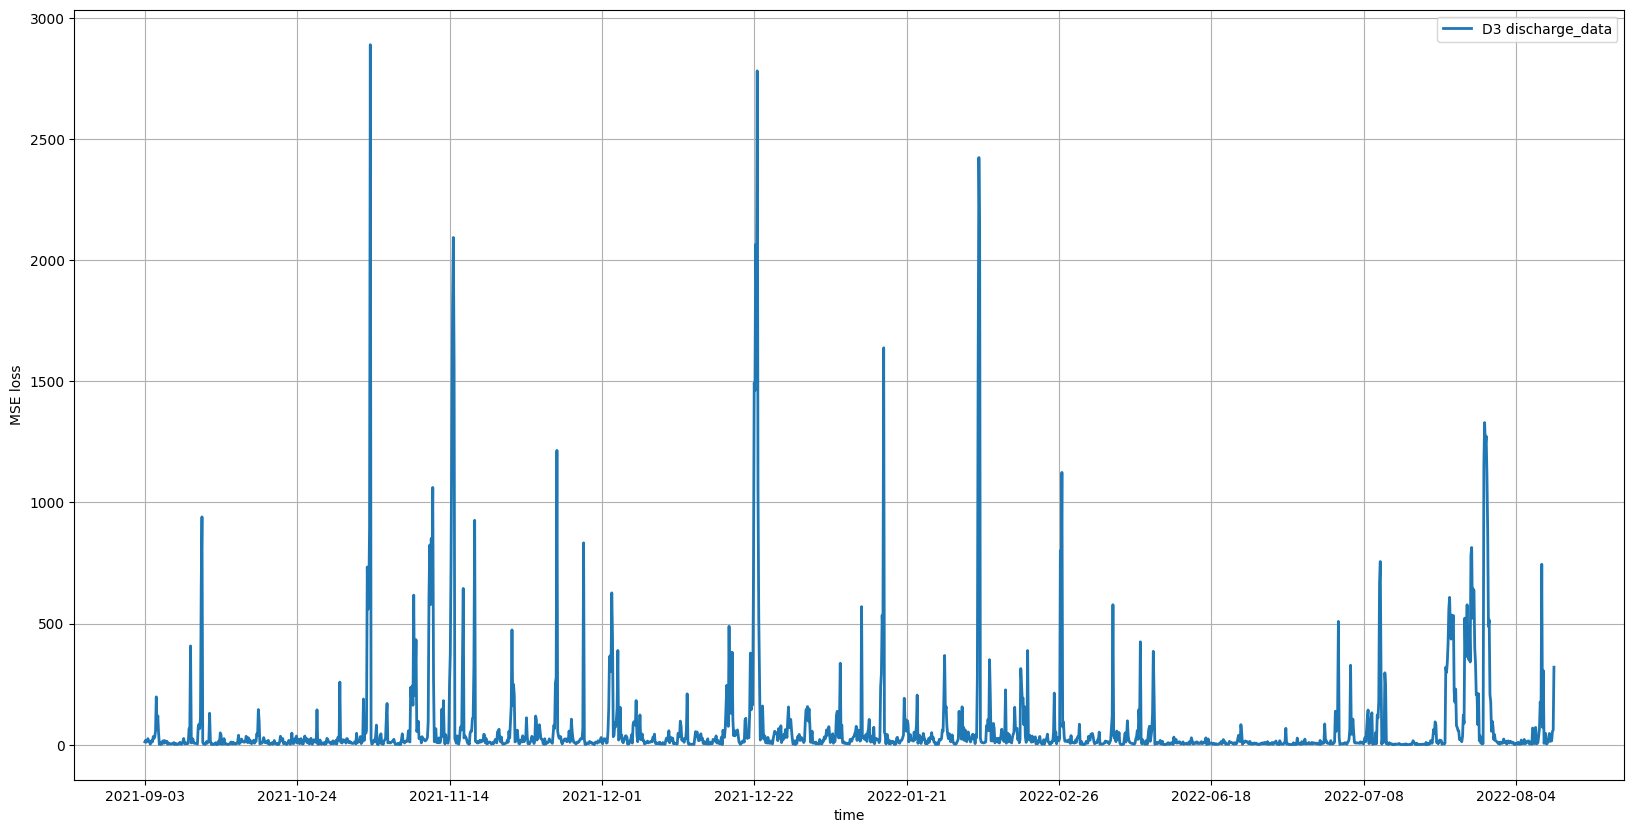

<Figure size 640x480 with 0 Axes>

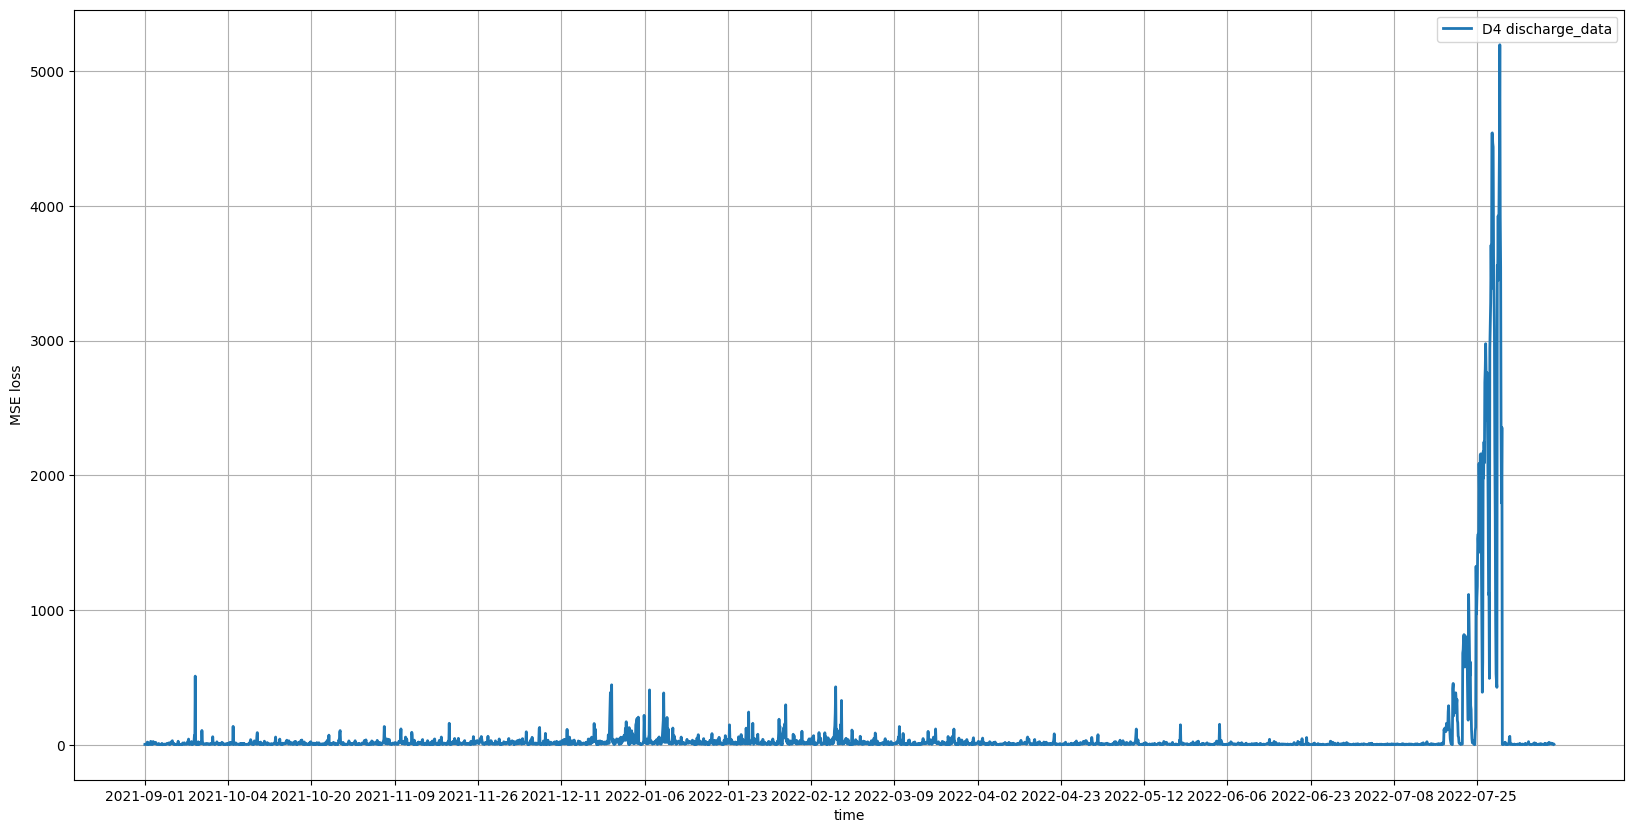

<Figure size 640x480 with 0 Axes>

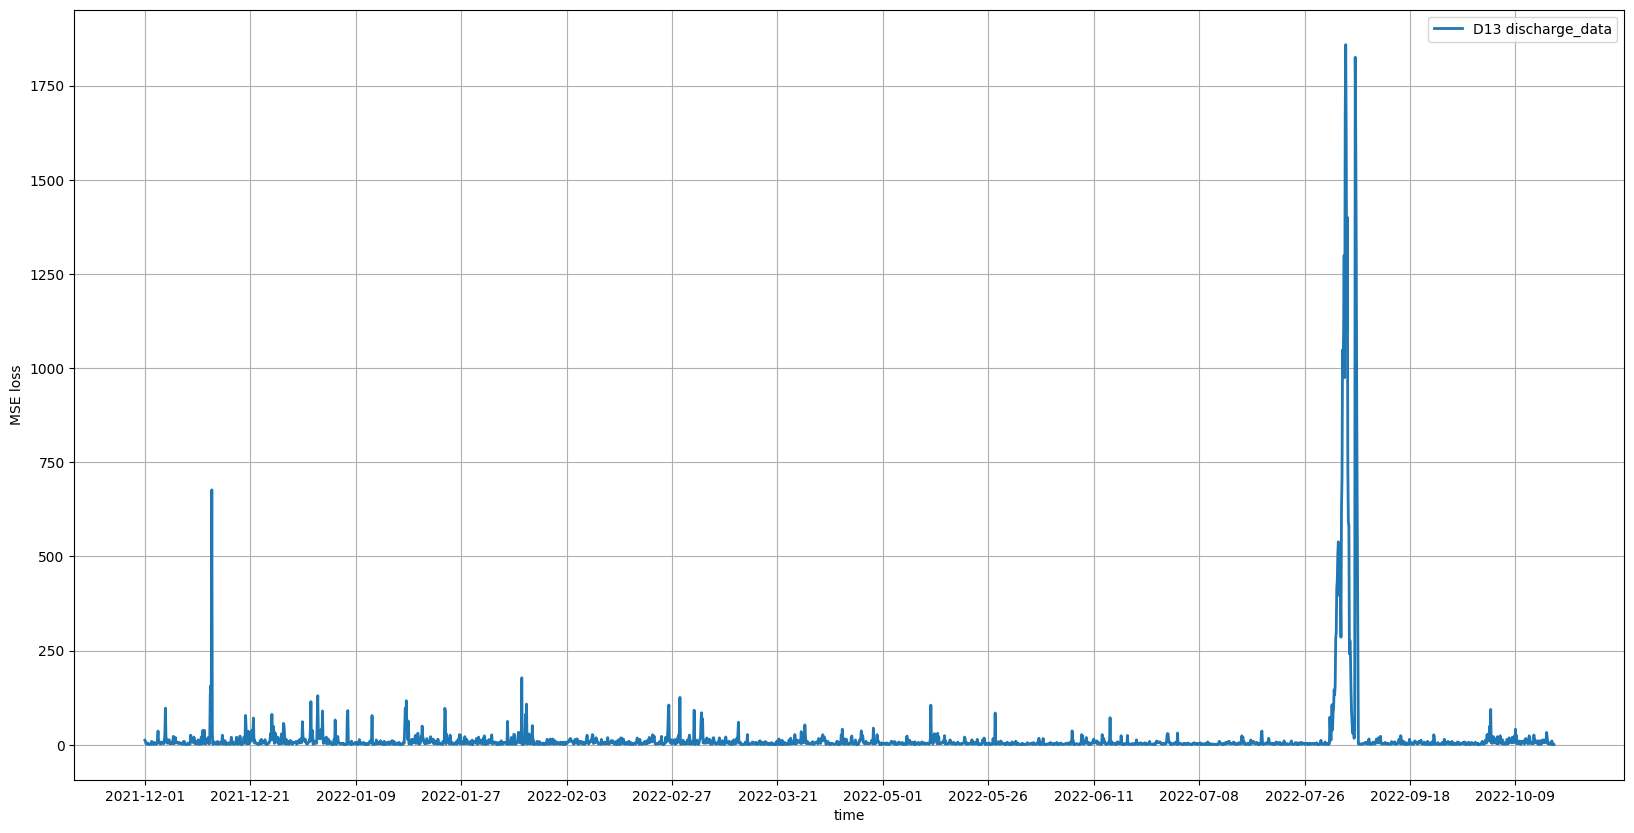

<Figure size 640x480 with 0 Axes>

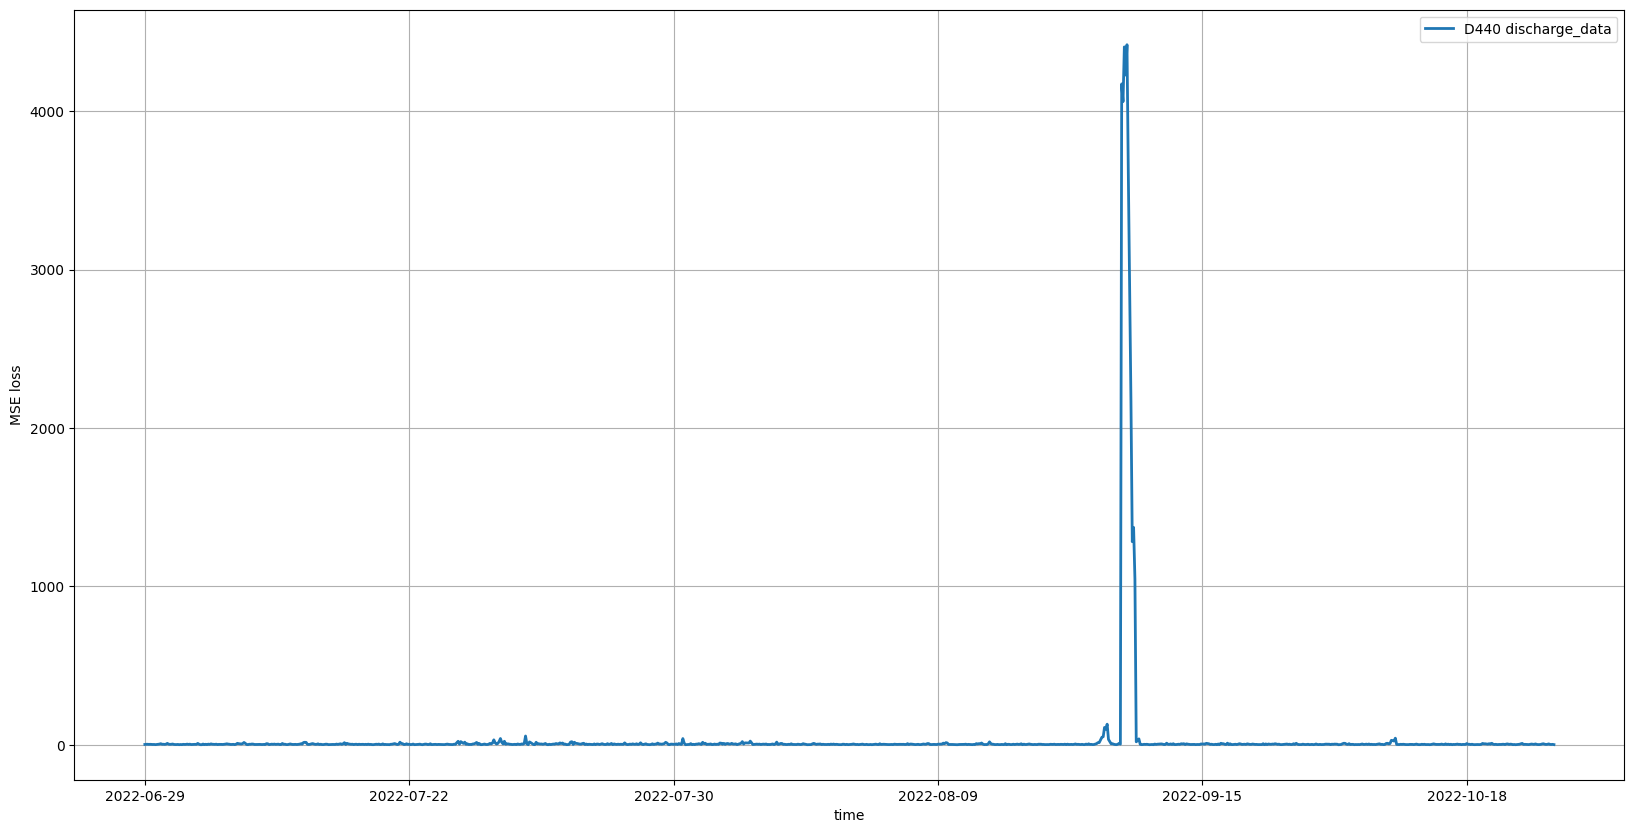

<Figure size 640x480 with 0 Axes>

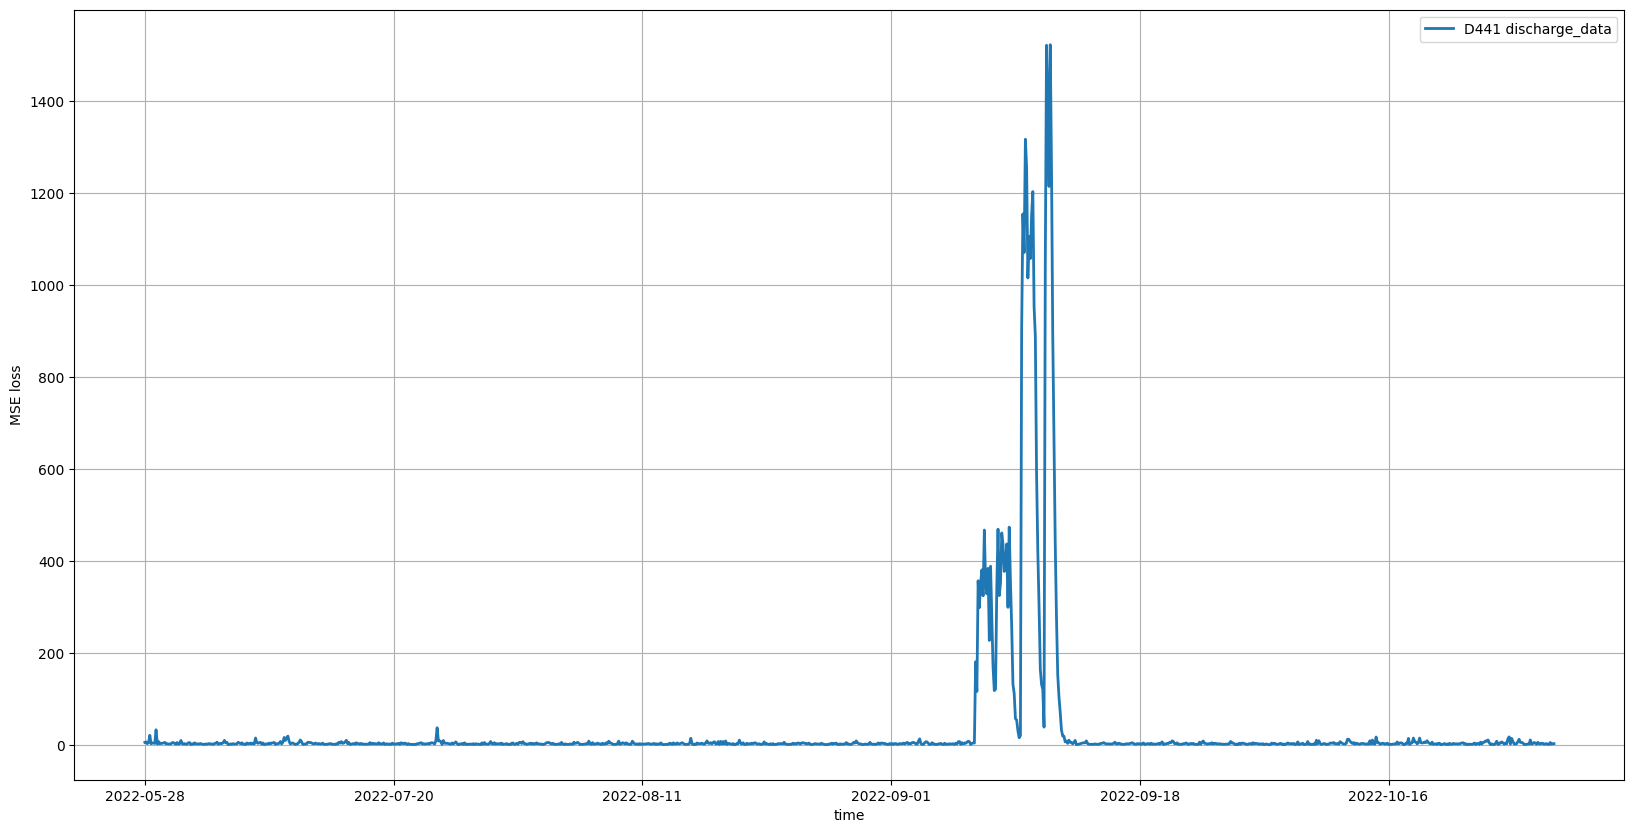

<Figure size 640x480 with 0 Axes>

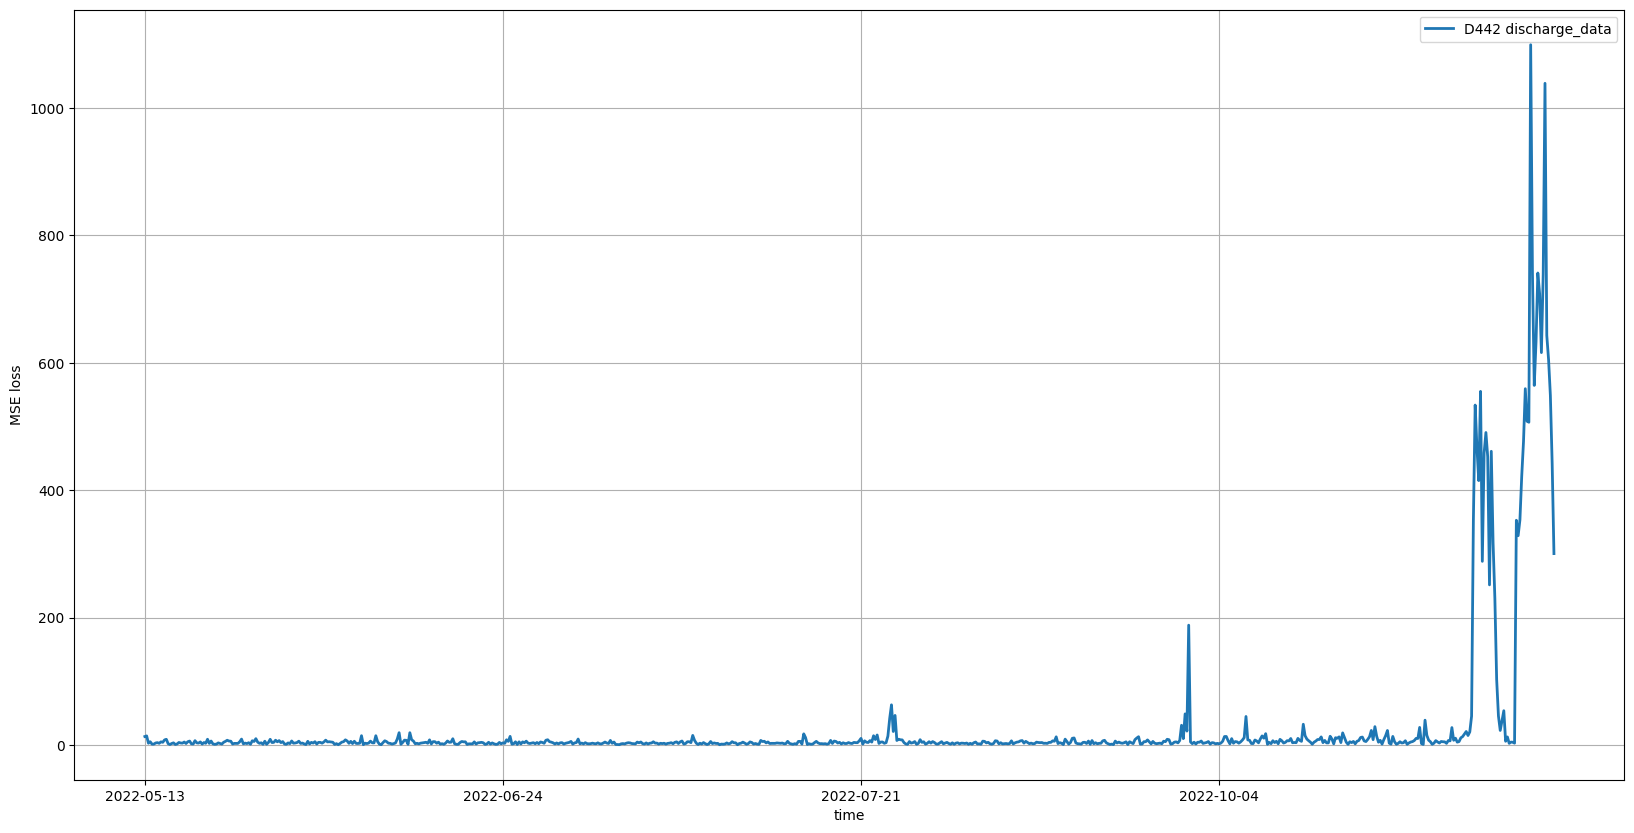

<Figure size 640x480 with 0 Axes>

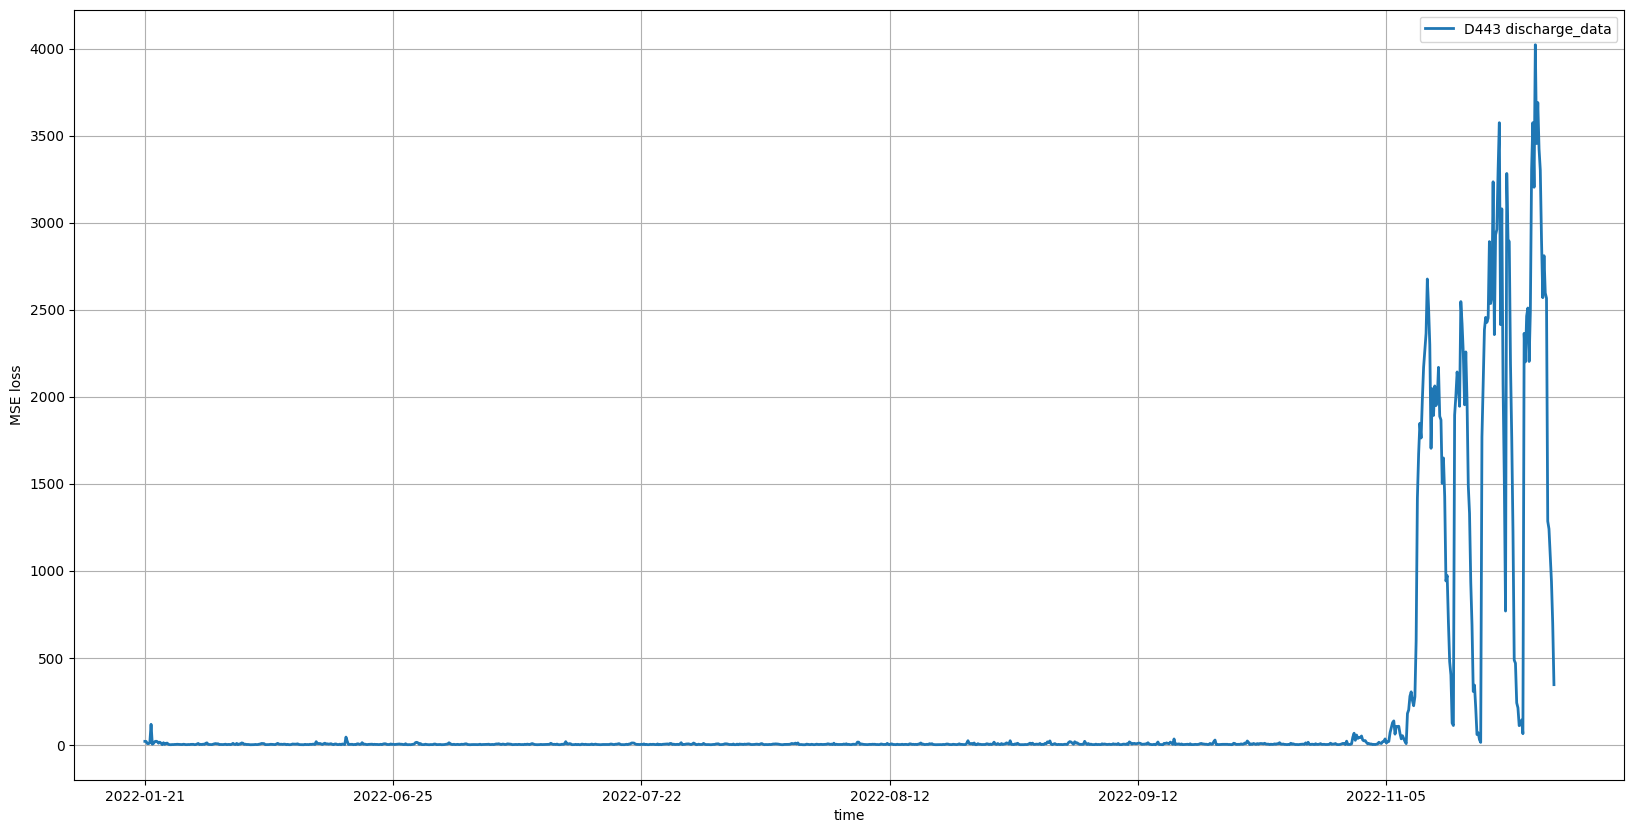

<Figure size 640x480 with 0 Axes>

In [235]:
car_name=['D1','D2','D3','D4','D13','D440','D441','D442','D443']
for car in car_name:
    plot_abnormal_score_trend(loss_file, car)

In [236]:
np.save('result_plot/abnormal_cars_discharge_mse.npy', loss_file)

In [237]:
loss_file = getTestResult('processed_data/normal_sample/discharge_data',MyModel,loss_fn,dataProcess, final_cols)

processed_data/normal_sample/discharge_data/D105_3.parquet
loss: 5.507680  [  101/ 1273]
loss: 1.500839  [  201/ 1273]
loss: 4.732863  [  301/ 1273]
loss: 5.964672  [  401/ 1273]
loss: 2.972599  [  501/ 1273]
loss: 0.851570  [  601/ 1273]
loss: 2.668163  [  701/ 1273]
loss: 4.921112  [  801/ 1273]
loss: 5.543773  [  901/ 1273]
loss: 9.658875  [ 1001/ 1273]
loss: 4.828574  [ 1101/ 1273]
loss: 5.748856  [ 1201/ 1273]
processed_data/normal_sample/discharge_data/D107_3.parquet
loss: 1.810933  [ 1301/ 2276]
loss: 7.891832  [ 1401/ 2276]
loss: 0.371659  [ 1501/ 2276]
loss: 1.380685  [ 1601/ 2276]
loss: 2.228408  [ 1701/ 2276]
loss: 2.624184  [ 1801/ 2276]
loss: 4.982519  [ 1901/ 2276]
loss: 3.269632  [ 2001/ 2276]
loss: 18.849534  [ 2101/ 2276]
loss: 36.218443  [ 2201/ 2276]
processed_data/normal_sample/discharge_data/D131_3.parquet
loss: 3.232100  [ 2301/ 3325]
loss: 10.390593  [ 2401/ 3325]
loss: 8.870181  [ 2501/ 3325]
loss: 26.372890  [ 2601/ 3325]
loss: 1.547973  [ 2701/ 3325]
loss: 18.

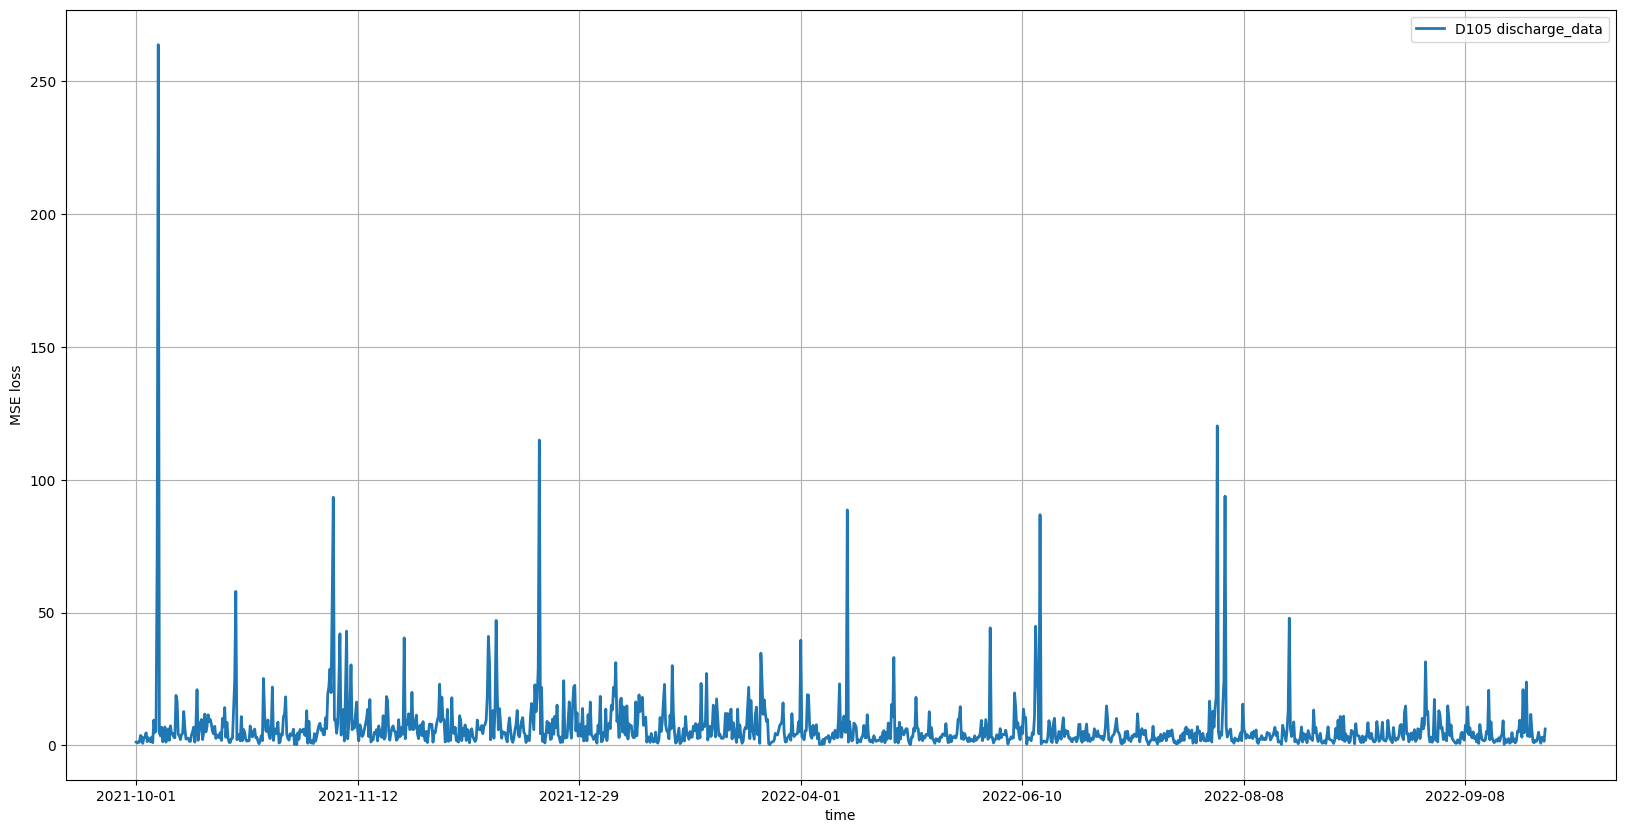

<Figure size 640x480 with 0 Axes>

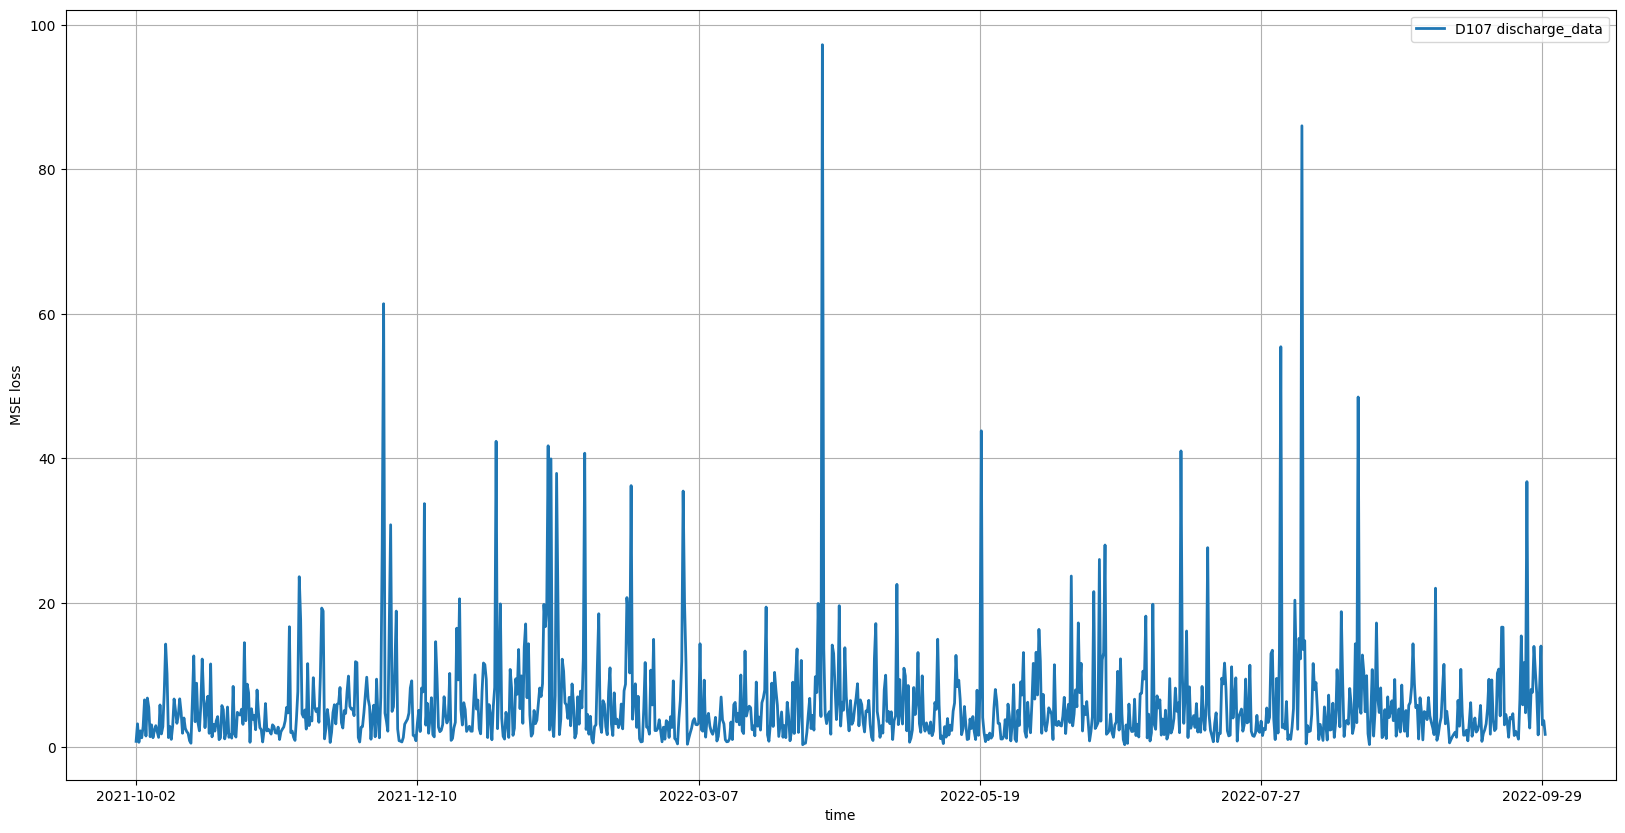

<Figure size 640x480 with 0 Axes>

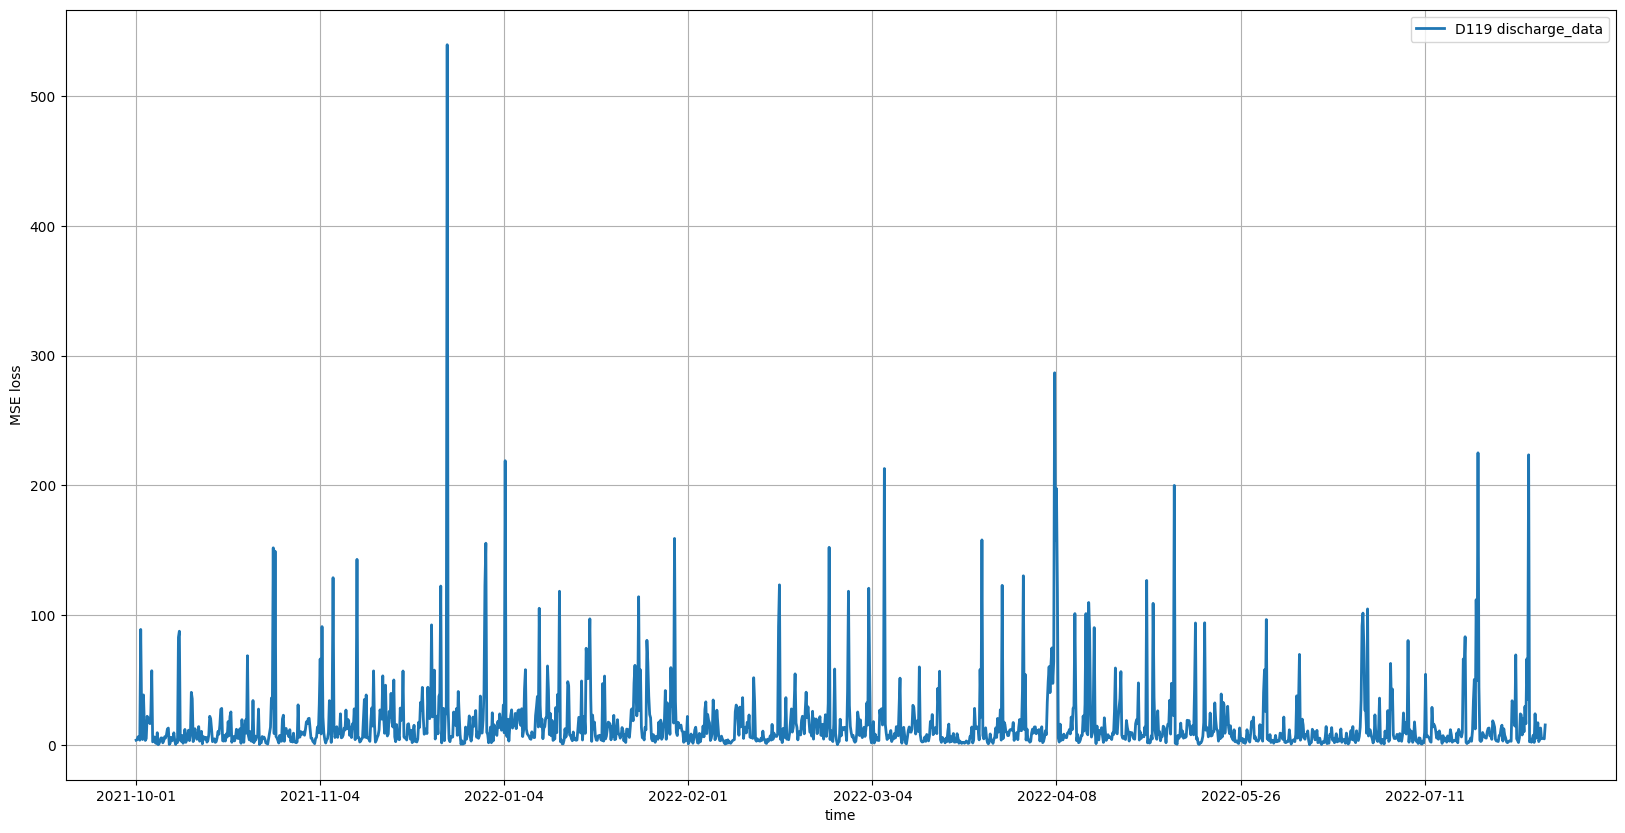

<Figure size 640x480 with 0 Axes>

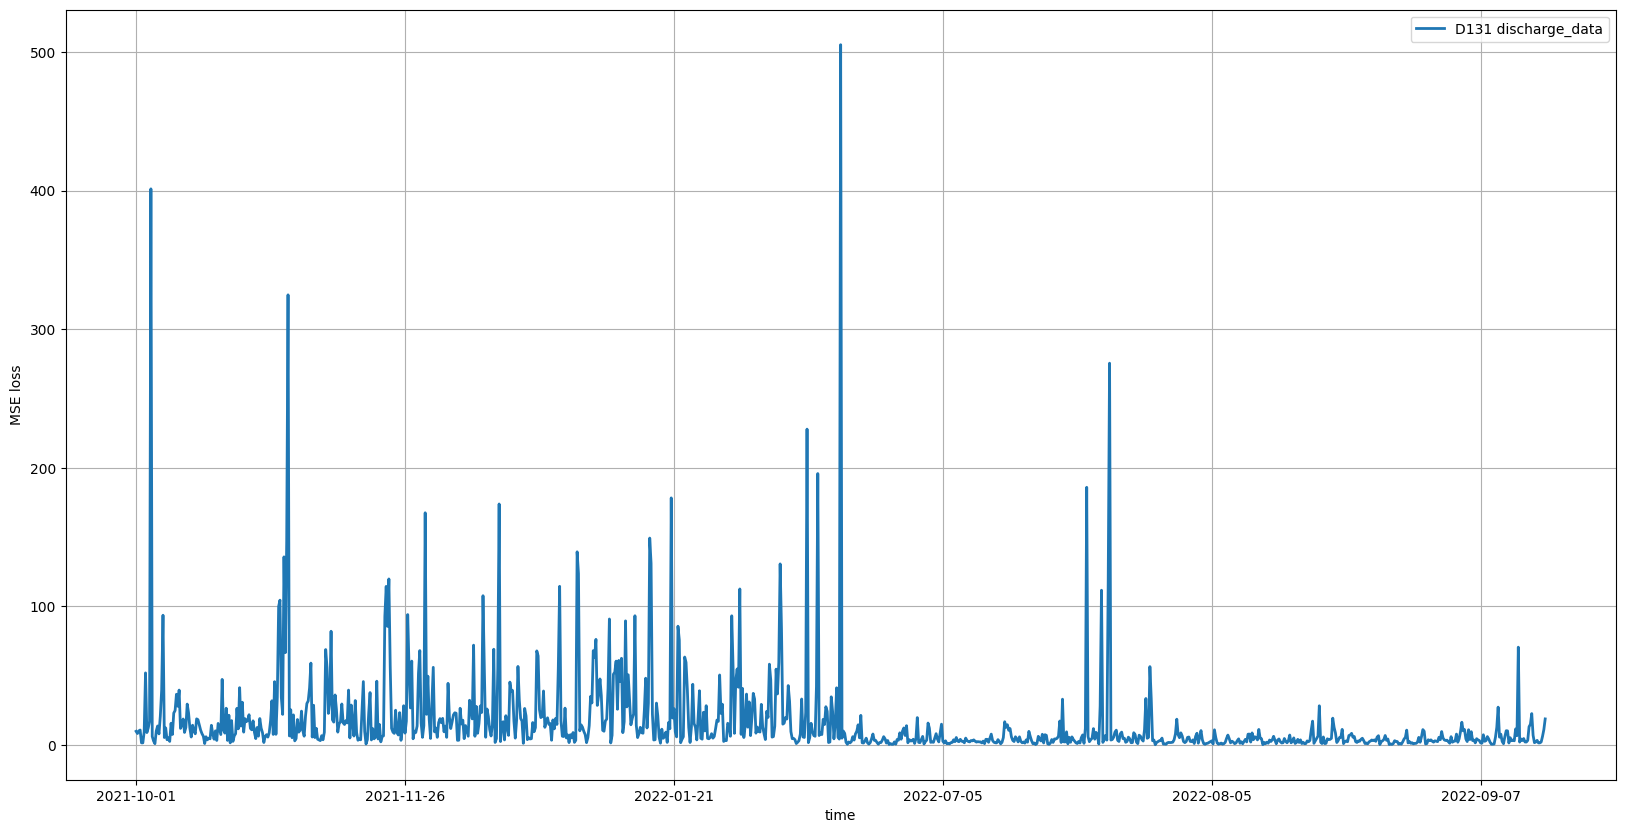

<Figure size 640x480 with 0 Axes>

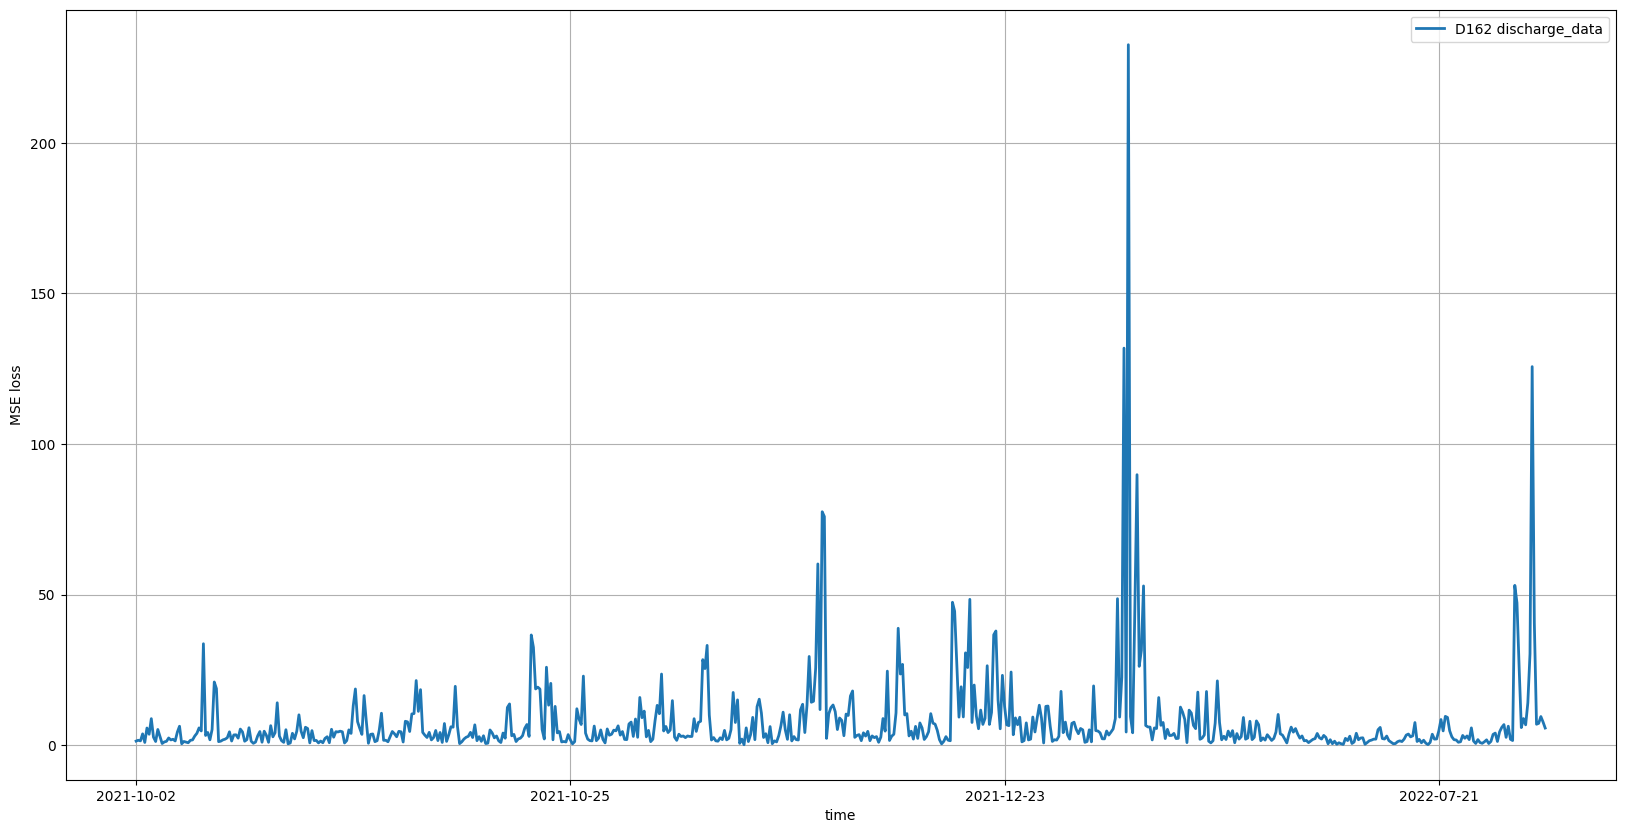

<Figure size 640x480 with 0 Axes>

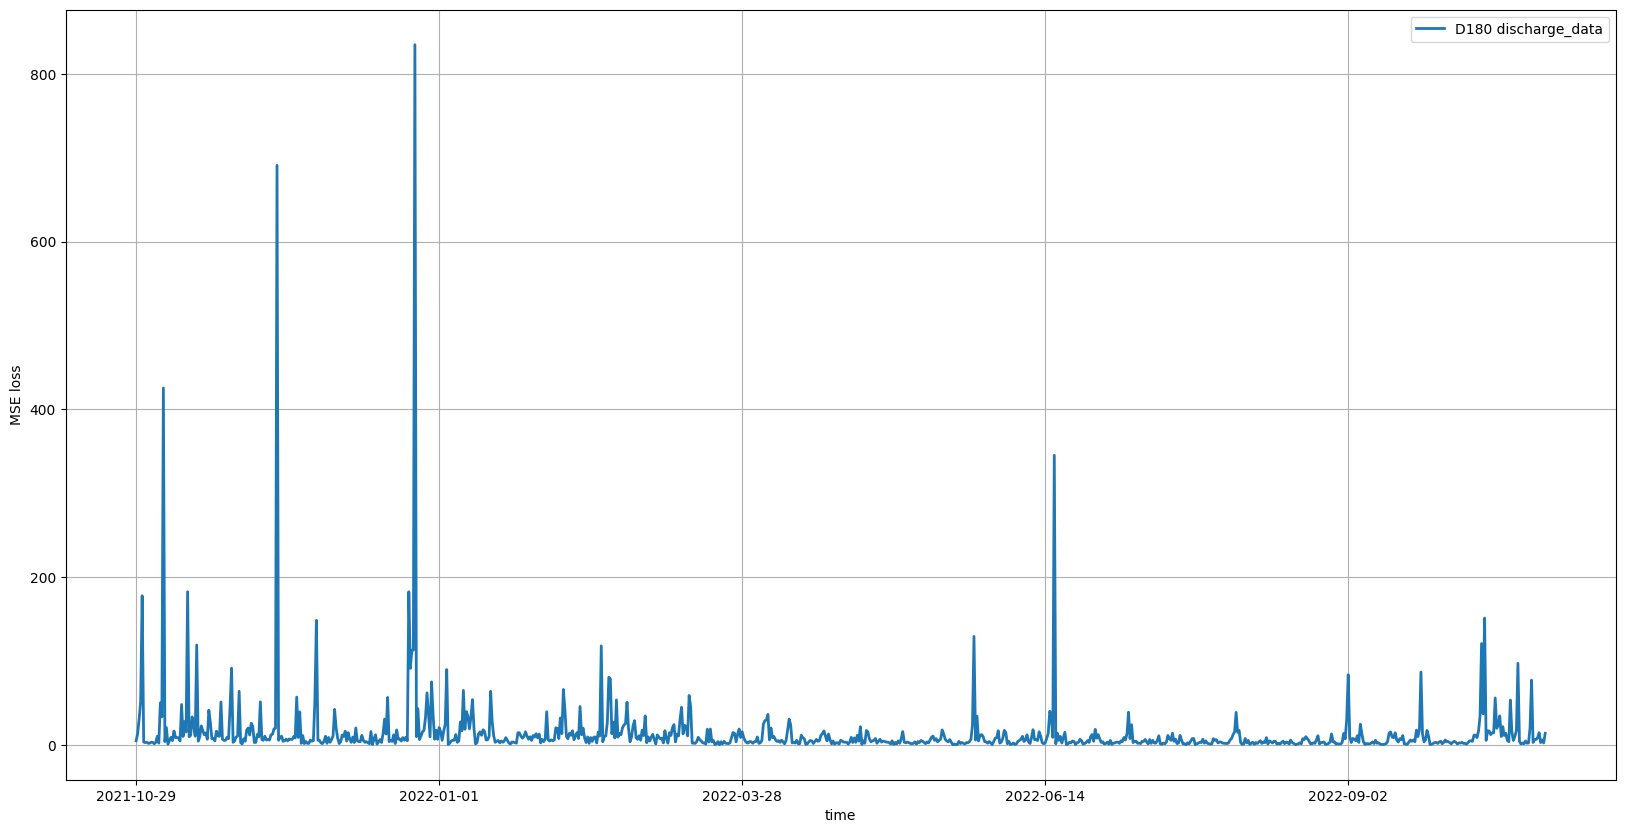

<Figure size 640x480 with 0 Axes>

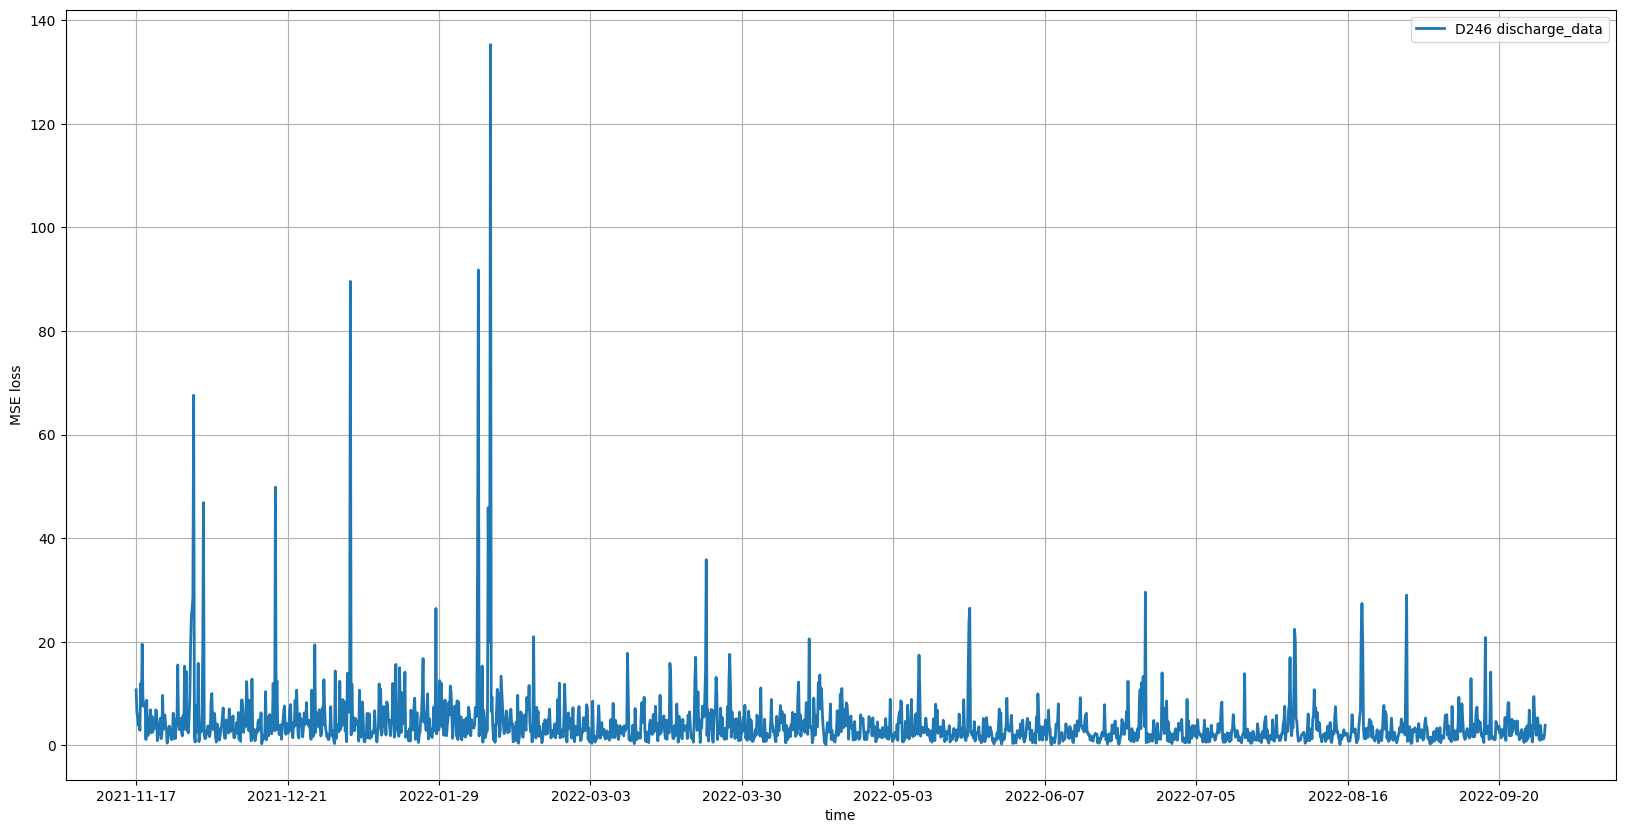

<Figure size 640x480 with 0 Axes>

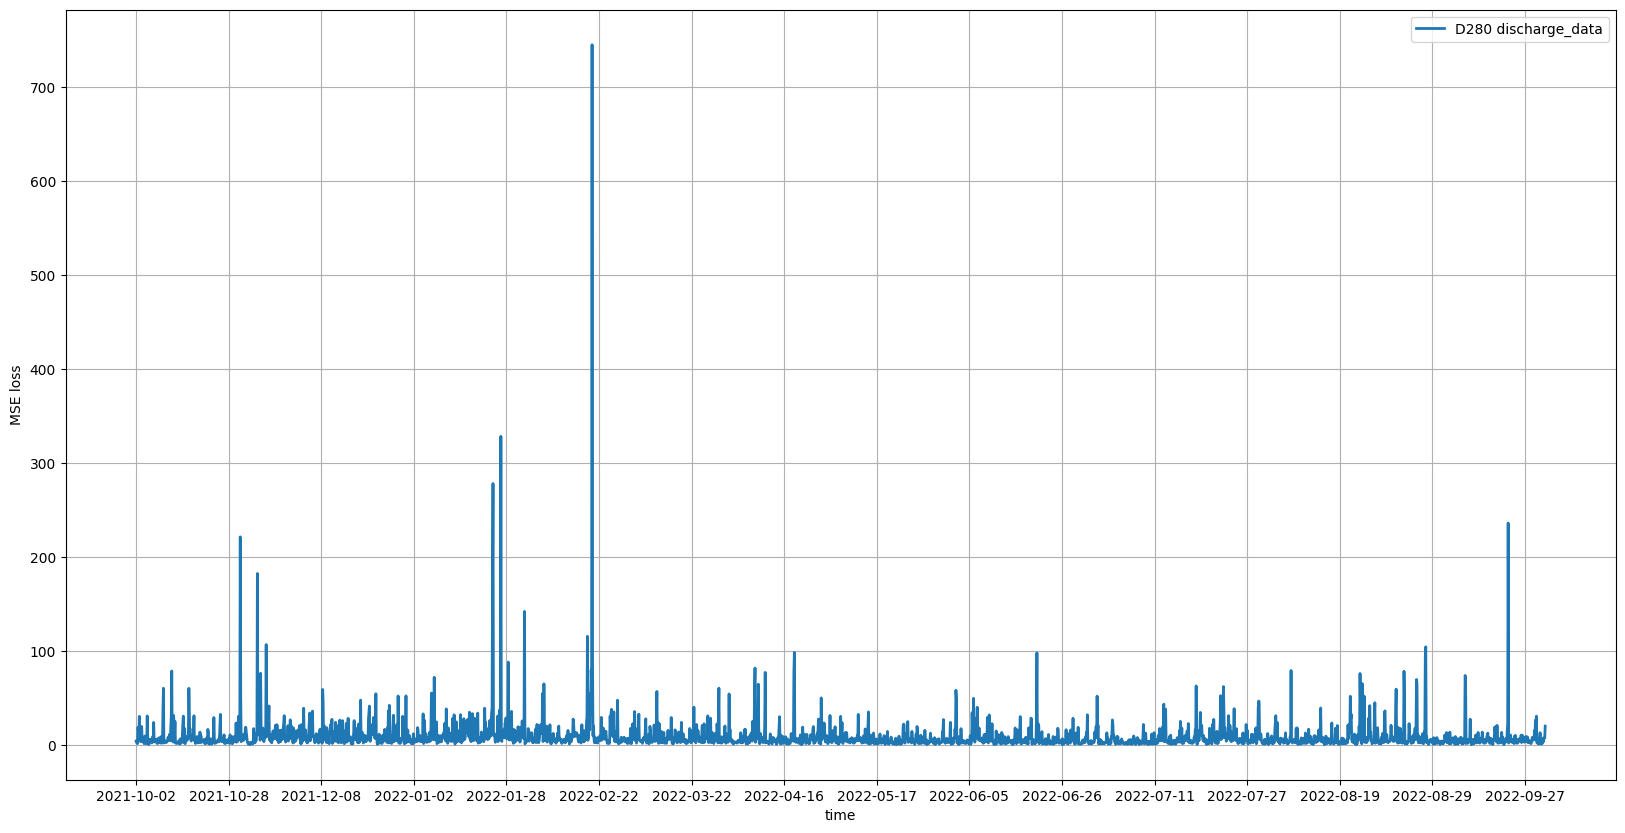

<Figure size 640x480 with 0 Axes>

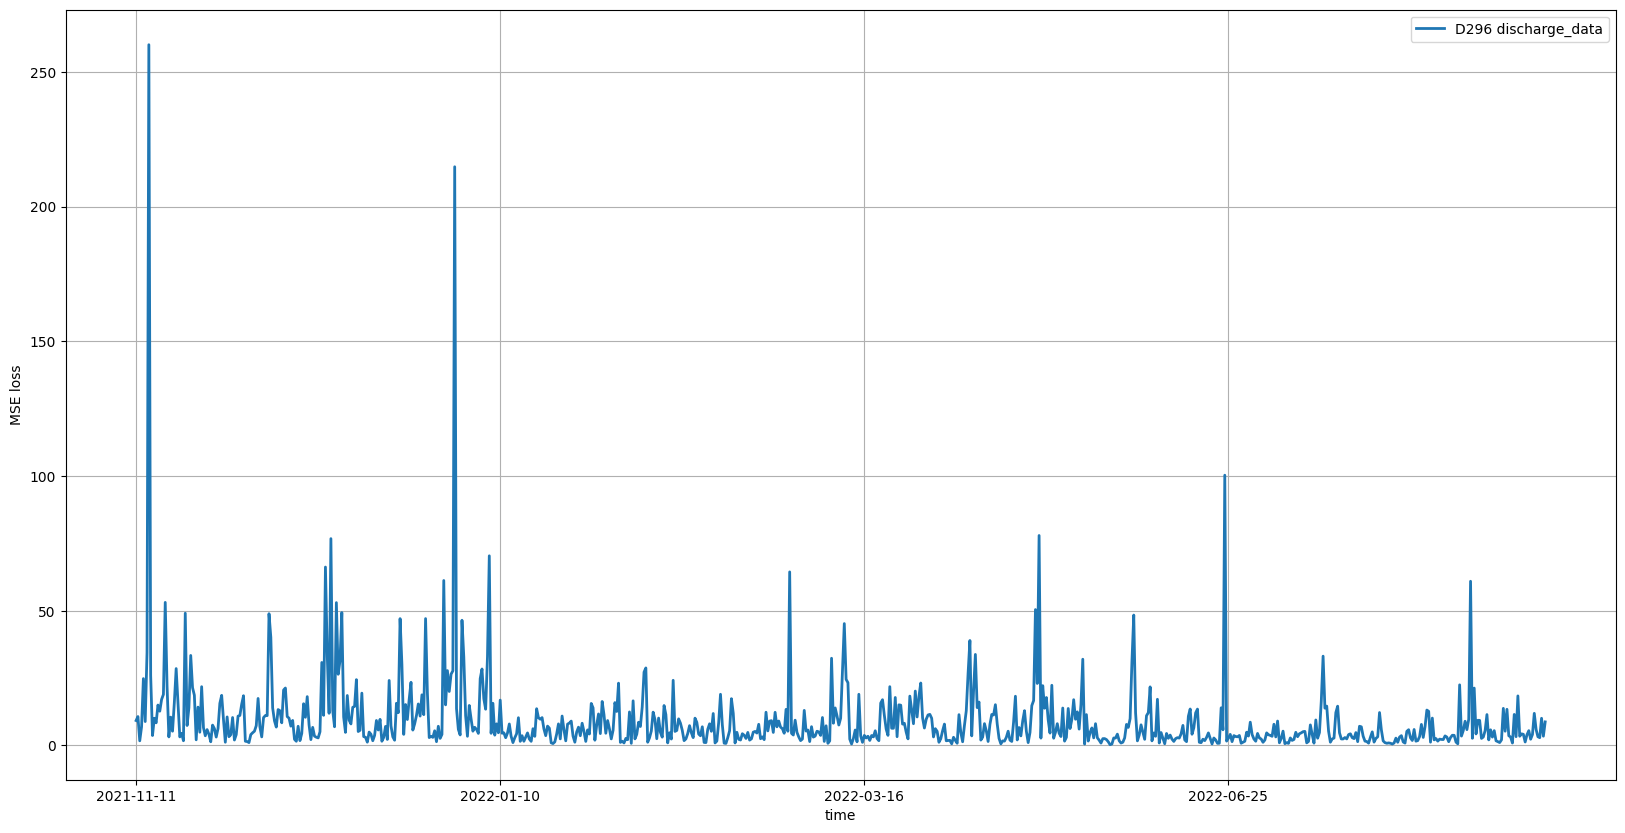

<Figure size 640x480 with 0 Axes>

In [238]:
car_name=['D105','D107','D119','D131','D162','D180','D246','D280','D296']
for car in car_name:
    plot_abnormal_score_trend(loss_file, car)

In [195]:
np.save('result_plot/normal_cars_discharge_mse.npy', loss_file)